# **Import Libraries**

In [31]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [32]:
!pip install optuna 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
%pip install lazypredict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
import nltk
import re
import spacy
import plotly.express as px
import plotly.graph_objects as go
import io
from plotly.offline import plot, iplot, init_notebook_mode
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew # for some statistics
import warnings # to ignore warning
from sklearn.preprocessing import RobustScaler, PowerTransformer, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

import lazypredict
from lazypredict.Supervised import LazyRegressor
import optuna
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LassoCV, RidgeCV

from sklearn.metrics import mean_absolute_error
import sklearn.metrics as metrics
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
import joblib

# **Read Data**

In [35]:
target_df = pd.read_csv("train_label.csv")
train_df = pd.read_csv("train_features.csv")

In [36]:
# Add a key column to each dataset
train_df['key'] = range(len(train_df))
target_df['key'] = range(len(target_df))

# Merge the datasets using the key column
master_df = pd.merge(train_df, target_df, on='key')

# Remove the key column
master_df = master_df.drop('key', axis=1)

master_df

,facilities,rating,location,Price
0,RestaurantBARSwimmingPools,7.8 Very GoodFrom 10 reviews,Stokol,"13,500avg/night"
1,intrnetRestaurantgym,5.6 GoodFrom 4 reviews,Machlessvile,"13,000avg/night"
2,restaurantgympoolBar,7.2 Very GoodFrom 38 reviews,Wanderland,"19,000avg/night"
3,BARRestaurant,7.3 Very GoodFrom 6 reviews,Uberlandia,"6,000avg/night"
4,InternetRestaurant,7.2 Very GoodFrom 30 reviews,Stokol,"20,000avg/night"
...,...,...,...,...
3061,barInternet,NaN,Andeman,"31,625avg/night"
3062,restaurantBarInternet,8.1 ExcellentFrom 4 reviews,Uberlandia,"30,500avg/night"
3063,Barrestaurantswimmingpools,6.7 Very GoodFrom 10 reviews,Willsmian,"14,000avg/night"
3064,Restaurant,NaN,Hallerson,"8,500avg/night"


In [37]:
# Size Dataset
print('Size dataset:', master_df.shape)

Size dataset: (3066, 4)


In [38]:
# Data Overview
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3066 entries, 0 to 3065
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   facilities  2765 non-null   object
 1   rating      2429 non-null   object
 2   location    3066 non-null   object
 3   Price       3066 non-null   object
dtypes: object(4)
memory usage: 119.8+ KB


# **Data Preprocessing**

# Feature Engineering

In [39]:
# Change type obj to str
master_df = master_df.astype({"facilities":"str","rating":"str","Price":"str"})

Ubah tipe data untuk features 'facilities', 'rating', dan 'Price' dari object ke string supaya dapat digunakan modul nltk

###**Cleaning Feature 'rating'**

In [40]:
# Download required resources from NLTK
nltk.download('punkt')

# Define a function to extract rating, review, and total reviews
def extract_info(text):
    tokens = nltk.word_tokenize(str(text))  # Convert to string
    rating = tokens[0]
    review = tokens[1:-2]
    total_reviews = tokens[-2] if len(tokens) >= 2 else None
    return rating, review, total_reviews

# Apply the function to the 'rating' column
master_df[['rating', 'review', 'total reviews']] = master_df['rating'].apply(extract_info).apply(pd.Series)

master_df

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,facilities,rating,location,Price,review,total reviews
0,RestaurantBARSwimmingPools,7.8,Stokol,"13,500avg/night","[Very, GoodFrom]",10
1,intrnetRestaurantgym,5.6,Machlessvile,"13,000avg/night",[GoodFrom],4
2,restaurantgympoolBar,7.2,Wanderland,"19,000avg/night","[Very, GoodFrom]",38
3,BARRestaurant,7.3,Uberlandia,"6,000avg/night","[Very, GoodFrom]",6
4,InternetRestaurant,7.2,Stokol,"20,000avg/night","[Very, GoodFrom]",30
...,...,...,...,...,...,...
3061,barInternet,nan,Andeman,"31,625avg/night",[],None
3062,restaurantBarInternet,8.1,Uberlandia,"30,500avg/night",[ExcellentFrom],4
3063,Barrestaurantswimmingpools,6.7,Willsmian,"14,000avg/night","[Very, GoodFrom]",10
3064,Restaurant,nan,Hallerson,"8,500avg/night",[],None


Pisahkan data pada feature 'rating' menjadi 3 features baru yaitu 'rating' yang berisi rating pengunjung terhadap Kyozo hotel, 'review' yaitu keseluruhan review yang diberikan pengunjung, dan 'total reviews' yaitu banyaknya pengunjung yang melakukan review.

In [41]:
# Replace NaN, empty list, and None with NaN
master_df['rating'] = master_df['rating'].replace('nan', np.nan)
master_df['review'] = master_df['review'].apply(lambda x: np.nan if len(x) == 0 else x)
master_df['total reviews'] = master_df['total reviews'].apply(lambda x: np.nan if x is None else x)

master_df

,facilities,rating,location,Price,review,total reviews
0,RestaurantBARSwimmingPools,7.8,Stokol,"13,500avg/night","[Very, GoodFrom]",10
1,intrnetRestaurantgym,5.6,Machlessvile,"13,000avg/night",[GoodFrom],4
2,restaurantgympoolBar,7.2,Wanderland,"19,000avg/night","[Very, GoodFrom]",38
3,BARRestaurant,7.3,Uberlandia,"6,000avg/night","[Very, GoodFrom]",6
4,InternetRestaurant,7.2,Stokol,"20,000avg/night","[Very, GoodFrom]",30
...,...,...,...,...,...,...
3061,barInternet,NaN,Andeman,"31,625avg/night",NaN,NaN
3062,restaurantBarInternet,8.1,Uberlandia,"30,500avg/night",[ExcellentFrom],4
3063,Barrestaurantswimmingpools,6.7,Willsmian,"14,000avg/night","[Very, GoodFrom]",10
3064,Restaurant,NaN,Hallerson,"8,500avg/night",NaN,NaN


###**Cleaning Feature 'facilities'**

In [42]:
# Define the dictionary of facilities
facilities_dict = {
    'restaurant': ['restaurant', 'food'],
    'bar': ['bar'],
    'swimming pool': ['pool', 'swimming', 'pools'],
    'gym': ['gym', 'fitness'],
    'internet': ['internet', 'intrnet']
}

# Function to separate the text into facilities based on the dictionary
def separate_facilities(text):
    separated_text = []
    for facility, keywords in facilities_dict.items():
        if any(keyword in text.lower() for keyword in keywords):
            separated_text.append(facility)
    return ', '.join(separated_text)

# Apply the separation function to the 'facilities' column
master_df['facilities'] = master_df['facilities'].apply(separate_facilities)

master_df

,facilities,rating,location,Price,review,total reviews
0,"restaurant, bar, swimming pool",7.8,Stokol,"13,500avg/night","[Very, GoodFrom]",10
1,"restaurant, gym, internet",5.6,Machlessvile,"13,000avg/night",[GoodFrom],4
2,"restaurant, bar, swimming pool, gym",7.2,Wanderland,"19,000avg/night","[Very, GoodFrom]",38
3,"restaurant, bar",7.3,Uberlandia,"6,000avg/night","[Very, GoodFrom]",6
4,"restaurant, internet",7.2,Stokol,"20,000avg/night","[Very, GoodFrom]",30
...,...,...,...,...,...,...
3061,"bar, internet",NaN,Andeman,"31,625avg/night",NaN,NaN
3062,"restaurant, bar, internet",8.1,Uberlandia,"30,500avg/night",[ExcellentFrom],4
3063,"restaurant, bar, swimming pool",6.7,Willsmian,"14,000avg/night","[Very, GoodFrom]",10
3064,restaurant,NaN,Hallerson,"8,500avg/night",NaN,NaN


Bersihkan data ada feature 'facilities' dengan memisahkan fasilitas-fasilitas yang ada pada Kyozo hotel menjadi data yang terurut.

In [43]:
# Identify distinct values in the 'facilities' feature
distinct_values = master_df['facilities'].str.split(', ').explode().unique()

print(distinct_values)

['restaurant' 'bar' 'swimming pool' 'gym' 'internet' '']


In [44]:
# Replace empty strings with NaN
master_df['facilities'] = master_df['facilities'].replace('', np.nan)
master_df

,facilities,rating,location,Price,review,total reviews
0,"restaurant, bar, swimming pool",7.8,Stokol,"13,500avg/night","[Very, GoodFrom]",10
1,"restaurant, gym, internet",5.6,Machlessvile,"13,000avg/night",[GoodFrom],4
2,"restaurant, bar, swimming pool, gym",7.2,Wanderland,"19,000avg/night","[Very, GoodFrom]",38
3,"restaurant, bar",7.3,Uberlandia,"6,000avg/night","[Very, GoodFrom]",6
4,"restaurant, internet",7.2,Stokol,"20,000avg/night","[Very, GoodFrom]",30
...,...,...,...,...,...,...
3061,"bar, internet",NaN,Andeman,"31,625avg/night",NaN,NaN
3062,"restaurant, bar, internet",8.1,Uberlandia,"30,500avg/night",[ExcellentFrom],4
3063,"restaurant, bar, swimming pool",6.7,Willsmian,"14,000avg/night","[Very, GoodFrom]",10
3064,restaurant,NaN,Hallerson,"8,500avg/night",NaN,NaN


In [45]:
# Feature engineering: 'have bar'
master_df['have bar'] = master_df['facilities'].apply(lambda x: 2 if pd.isna(x) else (1 if 'bar' in x else 0))

# Feature engineering: 'have restaurant'
master_df['have restaurant'] = master_df['facilities'].apply(lambda x: 2 if pd.isna(x) else (1 if 'restaurant' in x else 0))

# Feature engineering: 'have swimming pools'
master_df['have swimming pool'] = master_df['facilities'].apply(lambda x: 2 if pd.isna(x) else (1 if 'swimming pool' in x else 0))

# Feature engineering: 'have gym'
master_df['have gym'] = master_df['facilities'].apply(lambda x: 2 if pd.isna(x) else (1 if 'gym' in x else 0))

# Feature engineering: 'have internet'
master_df['have internet'] = master_df['facilities'].apply(lambda x: 2 if pd.isna(x) else (1 if 'internet' in x else 0))

master_df

,facilities,rating,location,Price,review,total reviews,have bar,have restaurant,have swimming pool,have gym,have internet
0,"restaurant, bar, swimming pool",7.8,Stokol,"13,500avg/night","[Very, GoodFrom]",10,1,1,1,0,0
1,"restaurant, gym, internet",5.6,Machlessvile,"13,000avg/night",[GoodFrom],4,0,1,0,1,1
2,"restaurant, bar, swimming pool, gym",7.2,Wanderland,"19,000avg/night","[Very, GoodFrom]",38,1,1,1,1,0
3,"restaurant, bar",7.3,Uberlandia,"6,000avg/night","[Very, GoodFrom]",6,1,1,0,0,0
4,"restaurant, internet",7.2,Stokol,"20,000avg/night","[Very, GoodFrom]",30,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
3061,"bar, internet",NaN,Andeman,"31,625avg/night",NaN,NaN,1,0,0,0,1
3062,"restaurant, bar, internet",8.1,Uberlandia,"30,500avg/night",[ExcellentFrom],4,1,1,0,0,1
3063,"restaurant, bar, swimming pool",6.7,Willsmian,"14,000avg/night","[Very, GoodFrom]",10,1,1,1,0,0
3064,restaurant,NaN,Hallerson,"8,500avg/night",NaN,NaN,0,1,0,0,0


###**Cleaning Feature 'Price'**

In [46]:
# Remove non-numeric characters from the 'Price' column
master_df['Price'] = master_df['Price'].str.replace(',', '').str.extract('(\d+)')

# Convert the 'Price' column to integer type
master_df['Price'] = master_df['Price'].astype(int)

master_df

,facilities,rating,location,Price,review,total reviews,have bar,have restaurant,have swimming pool,have gym,have internet
0,"restaurant, bar, swimming pool",7.8,Stokol,13500,"[Very, GoodFrom]",10,1,1,1,0,0
1,"restaurant, gym, internet",5.6,Machlessvile,13000,[GoodFrom],4,0,1,0,1,1
2,"restaurant, bar, swimming pool, gym",7.2,Wanderland,19000,"[Very, GoodFrom]",38,1,1,1,1,0
3,"restaurant, bar",7.3,Uberlandia,6000,"[Very, GoodFrom]",6,1,1,0,0,0
4,"restaurant, internet",7.2,Stokol,20000,"[Very, GoodFrom]",30,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
3061,"bar, internet",NaN,Andeman,31625,NaN,NaN,1,0,0,0,1
3062,"restaurant, bar, internet",8.1,Uberlandia,30500,[ExcellentFrom],4,1,1,0,0,1
3063,"restaurant, bar, swimming pool",6.7,Willsmian,14000,"[Very, GoodFrom]",10,1,1,1,0,0
3064,restaurant,NaN,Hallerson,8500,NaN,NaN,0,1,0,0,0


# Handle Missing Values

In [47]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3066 entries, 0 to 3065
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   facilities          2765 non-null   object
 1   rating              2429 non-null   object
 2   location            3066 non-null   object
 3   Price               3066 non-null   int64 
 4   review              2406 non-null   object
 5   total reviews       2429 non-null   object
 6   have bar            3066 non-null   int64 
 7   have restaurant     3066 non-null   int64 
 8   have swimming pool  3066 non-null   int64 
 9   have gym            3066 non-null   int64 
 10  have internet       3066 non-null   int64 
dtypes: int64(6), object(5)
memory usage: 287.4+ KB


In [48]:
# Missing Value
print('The number of missing value on dataset:')
master_df.isna().sum()

The number of missing value on dataset:


facilities            301
rating                637
location                0
Price                   0
review                660
total reviews         637
have bar                0
have restaurant         0
have swimming pool      0
have gym                0
have internet           0
dtype: int64

In [49]:
# Check percentage of missing values
master_df.isna().sum()/len(master_df)*100

facilities            9.82
rating               20.78
location              0.00
Price                 0.00
review               21.53
total reviews        20.78
have bar              0.00
have restaurant       0.00
have swimming pool    0.00
have gym              0.00
have internet         0.00
dtype: float64

<Axes: >

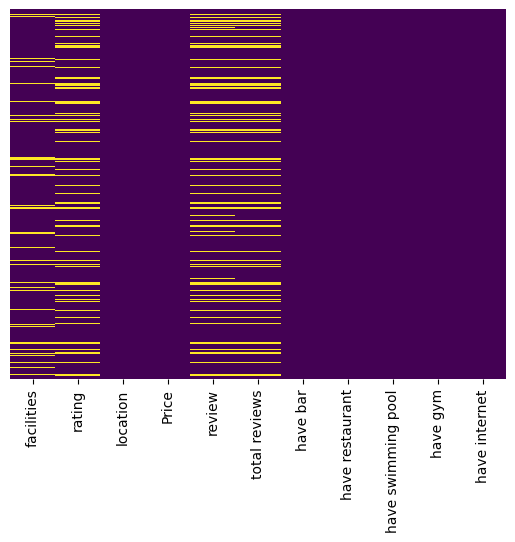

In [50]:
# Plot missing values
sns.heatmap(master_df.isna(),yticklabels=False,cbar=False,cmap='viridis')

Karena terdapat banyak missing value pada features 'facilities' dan 'rating', maka kita perlu menemukan hubungan antara missing value dengan variabel target 'price'.

# Model Prediction Missing Values

In [ ]:
# Identify distinct values in the 'location' feature
distinct_values_loc = master_df['location'].unique()

print(distinct_values_loc)

['Stokol' 'Machlessvile' 'Wanderland' 'Uberlandia' 'Hallerson' 'Willsmian'
 'Andeman' 'Ubisville']


In [52]:
le = LabelEncoder()
# Fit and transform the 'location' column using LabelEncoder
le.fit(master_df['location'].drop_duplicates())
master_df['location'] = le.transform(master_df['location'])

###**Prediction 'rating'**

In [53]:
# Replace 'From' with NaN
master_df['rating'] = master_df['rating'].replace('From', np.nan)

In [54]:
# Separate features with missing values and without missing values
train_data = master_df.dropna(subset=['rating'])  # Replace 'target_feature' with the name of the feature with missing values
test_data = master_df[master_df['rating'].isnull()]

# Split the train and test data into X (features) and y (target)
X_train = train_data.drop(columns=['rating', 'review', 'facilities', 'total reviews'])
y_train = train_data['rating'].astype(float)

X_test = test_data.drop(columns=['rating', 'review', 'facilities', 'total reviews'])

# Perform train-test split on the train data
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Print the shapes of train and test sets
print("Train set shape:", X_train_split.shape, y_train_split.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape)

Train set shape: (1924, 7) (1924,)
Validation set shape: (482, 7) (482,)
Test set shape: (660, 7)


In [55]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2406 entries, 0 to 3065
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   location            2406 non-null   int64
 1   Price               2406 non-null   int64
 2   have bar            2406 non-null   int64
 3   have restaurant     2406 non-null   int64
 4   have swimming pool  2406 non-null   int64
 5   have gym            2406 non-null   int64
 6   have internet       2406 non-null   int64
dtypes: int64(7)
memory usage: 150.4 KB


In [56]:
y_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 2406 entries, 0 to 3065
Series name: rating
Non-Null Count  Dtype  
--------------  -----  
2406 non-null   float64
dtypes: float64(1)
memory usage: 37.6 KB


In [57]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [58]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_split, y_train_split)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [59]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('MAE: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy
    
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train_split, y_train_split)
base_accuracy = evaluate(base_model, X_val, y_val)

Model Performance
MAE: 0.4607 degrees.
Accuracy = 91.86%.


In [60]:
# Make predictions on the test data
y_pred_rat = base_model.predict(X_test)

# Replace the missing values in the 'rating' column with the predicted values
master_df.loc[master_df['rating'].isnull(), 'rating'] = y_pred_rat

master_df['rating'].astype(float)

0      7.80
1      5.60
2      7.20
3      7.30
4      7.20
       ... 
3061   7.28
3062   8.10
3063   6.70
3064   6.60
3065   7.80
Name: rating, Length: 3066, dtype: float64

###**Prediction 'total reviews'**

In [61]:
# Separate features with missing values and without missing values
train_data = master_df.dropna(subset=['total reviews'])  # Replace 'target_feature' with the name of the feature with missing values
test_data = master_df[master_df['total reviews'].isnull()]

# Split the train and test data into X (features) and y (target)
X_train = train_data.drop(columns=['total reviews', 'review', 'facilities'])
y_train = train_data['total reviews'].astype(float)

X_test = test_data.drop(columns=['review', 'facilities', 'total reviews'])

# Perform train-test split on the train data
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Print the shapes of train and test sets
print("Train set shape:", X_train_split.shape, y_train_split.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape)

Train set shape: (1943, 8) (1943,)
Validation set shape: (486, 8) (486,)
Test set shape: (637, 8)


In [62]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2429 entries, 0 to 3065
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   rating              2429 non-null   object
 1   location            2429 non-null   int64 
 2   Price               2429 non-null   int64 
 3   have bar            2429 non-null   int64 
 4   have restaurant     2429 non-null   int64 
 5   have swimming pool  2429 non-null   int64 
 6   have gym            2429 non-null   int64 
 7   have internet       2429 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 170.8+ KB


In [63]:
y_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 2429 entries, 0 to 3065
Series name: total reviews
Non-Null Count  Dtype  
--------------  -----  
2429 non-null   float64
dtypes: float64(1)
memory usage: 38.0 KB


In [64]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [65]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_split, y_train_split)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [66]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('MAE: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy
    
best_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
best_model.fit(X_train_split, y_train_split)
best_accuracy = evaluate(best_model, X_val, y_val)

Model Performance
MAE: 1.5710 degrees.
Accuracy = 50.41%.


In [67]:
# Make predictions on the test data
y_pred_rev = best_model.predict(X_test)

# Replace the missing values in the 'rating' column with the predicted values
master_df.loc[master_df['total reviews'].isnull(), 'total reviews'] = y_pred_rev

# Mengganti Data Missing Values

In [68]:
# Nan: Diasumsikan lupa / tidak tahu fasilitas apa saja yang ada
master_df.facilities.fillna('tidak tahu', inplace=True)

In [69]:
# Convert all elements in 'review' column to strings
master_df['review'] = master_df['review'].astype(str)

# Identify distinct values in the 'review' feature
distinct_values_review = master_df['review'].unique()

print(distinct_values_review)

["['Very', 'GoodFrom']" "['GoodFrom']" 'nan' "['ExcellentFrom']"
 "['FairFrom']"]


In [70]:
# Find max and min values in 'rating' based on each category in 'review'
for category in distinct_values_review:
    category_data = master_df[master_df['review'] == category]
    max_rating = category_data['rating'].max()
    min_rating = category_data['rating'].min()
    print(f"Category: {category}")
    print(f"Max Rating: {max_rating}")
    print(f"Min Rating: {min_rating}")
    print()

Category: ['Very', 'GoodFrom']
Max Rating: 7.9
Min Rating: 6.0

Category: ['GoodFrom']
Max Rating: 5.9
Min Rating: 4.0

Category: nan
Max Rating: 9.82
Min Rating: 2.3000000000000003

Category: ['ExcellentFrom']
Max Rating: 9.8
Min Rating: 10.0

Category: ['FairFrom']
Max Rating: 3.9
Min Rating: 2.0



In [71]:
# Fill missing values in 'review' based on 'rating'
for index, row in master_df.iterrows():
    rating = row['rating']
    if pd.isnull(row['review']):  # Check if 'review' is missing
        if rating >= 0 and rating < 3.9:
            master_df.at[index, 'review'] = "['FairFrom']"
        elif rating >= 4 and rating < 5.9:
            master_df.at[index, 'review'] = "['GoodFrom']"
        elif rating >= 6 and rating < 7.9:
            master_df.at[index, 'review'] = "['Very', 'GoodFrom']"
        elif rating >= 8 and rating <= 10:
            master_df.at[index, 'review'] = "['ExcellentFrom']"

# Print the updated 'review' column
print(master_df['review'])

0       ['Very', 'GoodFrom']
1               ['GoodFrom']
2       ['Very', 'GoodFrom']
3       ['Very', 'GoodFrom']
4       ['Very', 'GoodFrom']
                ...         
3061                     nan
3062       ['ExcellentFrom']
3063    ['Very', 'GoodFrom']
3064                     nan
3065    ['Very', 'GoodFrom']
Name: review, Length: 3066, dtype: object


<Axes: >

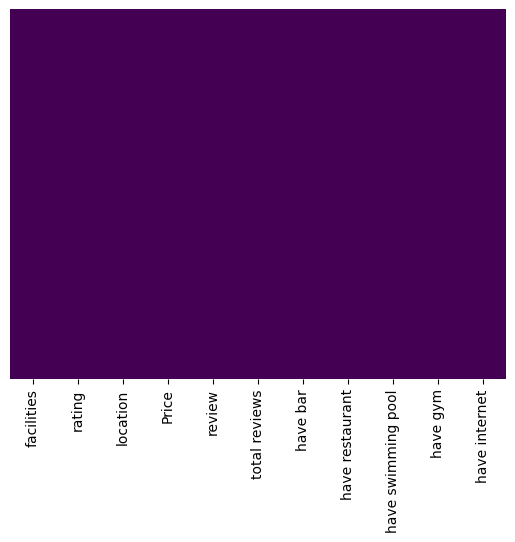

In [72]:
# Plot missing values
sns.heatmap(master_df.isna(),yticklabels=False,cbar=False,cmap='viridis')

Berdasarkan heatmap diatas data sudah bersih dari missing values karena missing values sudah berhasil diubah berdasarkan asumsi dan modus data

# Labeling Input Data

In [73]:
le = LabelEncoder()

# Fit and transform the 'review' column using LabelEncoder
le.fit(master_df['review'].drop_duplicates())
master_df['review'] = le.transform(master_df['review'])

In [74]:
master_df

,facilities,rating,location,Price,review,total reviews,have bar,have restaurant,have swimming pool,have gym,have internet
0,"restaurant, bar, swimming pool",7.8,3,13500,3,10,1,1,1,0,0
1,"restaurant, gym, internet",5.6,2,13000,2,4,0,1,0,1,1
2,"restaurant, bar, swimming pool, gym",7.2,6,19000,3,38,1,1,1,1,0
3,"restaurant, bar",7.3,4,6000,3,6,1,1,0,0,0
4,"restaurant, internet",7.2,3,20000,3,30,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
3061,"bar, internet",7.28,0,31625,4,14.10,1,0,0,0,1
3062,"restaurant, bar, internet",8.1,4,30500,0,4,1,1,0,0,1
3063,"restaurant, bar, swimming pool",6.7,7,14000,3,10,1,1,1,0,0
3064,restaurant,6.60,1,8500,4,8.10,0,1,0,0,0


Labeling feature 'review'

*   0 - Excellent
*   1 - Fair
*   2 - God
*   3 - Very Good

Labeling feature 'location'

*   0 - Andeman
*   1 - Hallerson
*   2 - Machlessvile
*   3 - Stokol
*   4 - Uberlandia
*   5 - Ubisville
*   6 - Wanderland
*   7 - Willsmian

In [75]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3066 entries, 0 to 3065
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   facilities          3066 non-null   object
 1   rating              3066 non-null   object
 2   location            3066 non-null   int64 
 3   Price               3066 non-null   int64 
 4   review              3066 non-null   int64 
 5   total reviews       3066 non-null   object
 6   have bar            3066 non-null   int64 
 7   have restaurant     3066 non-null   int64 
 8   have swimming pool  3066 non-null   int64 
 9   have gym            3066 non-null   int64 
 10  have internet       3066 non-null   int64 
dtypes: int64(8), object(3)
memory usage: 287.4+ KB


In [76]:
# Change type data
master_df = master_df.astype({"rating":"float","total reviews":"int"})
# Drop irelevant feature
master_df.drop(['facilities'], axis = 1, inplace = True)

# Lazy Predictions

Lazy Predict merupakan library Python yang menyediakan cara sederhana dan efisien untuk membuat prediksi. Lazy Predict adalah tools yang dapat memperlihatkan akurasi dari berbagai model untuk mempermudah proyek pemodelan prediktif.

In [77]:
X = master_df[['rating', 'location', 'review', 'total reviews',
       'have bar', 'have restaurant', 'have swimming pool', 'have gym',
       'have internet']]
y = master_df['Price']
X = X.astype(np.float32)
offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )
models,predictions = reg.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 42/42 [11:21<00:00, 16.23s/it]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreesRegressor,0.99,0.99,1977.55,0.43
DecisionTreeRegressor,0.99,0.99,2109.81,0.05
RandomForestRegressor,0.98,0.98,2602.66,0.65
XGBRegressor,0.97,0.97,2922.86,0.32
BaggingRegressor,0.96,0.96,3419.84,0.07
ExtraTreeRegressor,0.95,0.95,4040.39,0.05
HistGradientBoostingRegressor,0.85,0.86,6927.32,1.99
LGBMRegressor,0.84,0.85,7117.37,0.13
GradientBoostingRegressor,0.53,0.55,12265.41,0.27


# **Exploratory Data Analysis**



In [78]:
# Change type data
eda_df = master_df.astype({"rating":"float","location":"object","review":"object","total reviews":"int","have bar":"object",
                              "have restaurant":"object","have swimming pool":"object","have gym":"object","have internet":"object"})

In [79]:
# Unique Columns
eda_df.select_dtypes(include='object').nunique()

location              8
review                5
have bar              3
have restaurant       3
have swimming pool    3
have gym              3
have internet         3
dtype: int64

Features di atas memiliki tipe data object dengan yang memiliki kategori dengan jumlah masing-masing dapat dilihat diatas.

In [80]:
# Check duplicate values
eda_df.duplicated().sum()

438

Terdapat 438 data yang duplicate

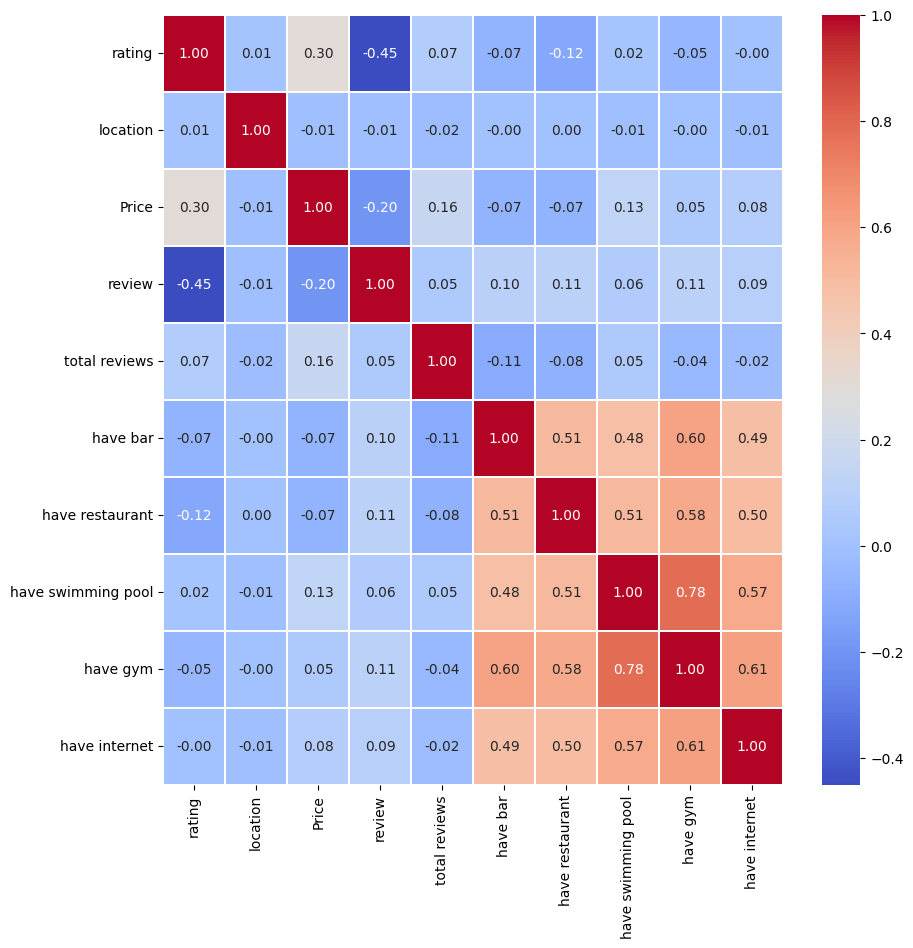

In [81]:
# Uji korelasi atribut
f, ax = plt.subplots(figsize=(10, 10))
corr = master_df.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm", fmt='.2f', linewidths=.05)

In [82]:
# Membuat grafik rata-rata harga hotel dengan total reviews dan review
fig = px.scatter(eda_df, x='total reviews', y='Price', color='review', size='Price',
                 title="Hotel Price increase with Total Reviews among Review",
                 color_discrete_sequence=['#B14B51','#B7A294'],height=600)
fig.update_layout(legend=dict(title='',orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
                  font_color="#303030", xaxis=dict(title='Total Reviews',showgrid=False), 
                  yaxis=dict(title='Hotel Price, $',showgrid=False, zerolinecolor='#E5E5EA',
                             showline=True, linecolor='#E5E5EA', linewidth=2))
fig.show()

# Categorical Data

In [83]:
import warnings
warnings.filterwarnings("ignore")

# get list of categorical variables
categoric = ['location', 'review', 'have bar', 'have restaurant', 'have swimming pool', 'have gym', 'have internet']

In [84]:
# Menunjukan statistika deskriptif dari variabel kategorik di dataset
# Filter the DataFrame to include only the categorical variables
categorical_df = eda_df[categoric]

# Use describe() on the categorical DataFrame
categorical_df.describe()

,location,review,have bar,have restaurant,have swimming pool,have gym,have internet
count,3066,3066,3066,3066,3066,3066,3066
unique,8,5,3,3,3,3,3
top,3,3,1,1,0,0,0
freq,561,1304,2221,2327,1740,2102,1459


In [85]:
# Menunjukan rata-rata harga hotel dari variabel kategorik
for i in categoric:
    obs=eda_df[i].value_counts()
    avg_price=eda_df.groupby(i)["Price"].mean()
    display(pd.DataFrame({"Number of Visitors":obs, "Average Price Hotel":avg_price.map('${:,.2f}'.format)})\
            .sort_values('Number of Visitors', ascending=False)\
            .style.set_caption("Variable: {}".format(i)))

,Number of Visitors,Average Price Hotel
3,561,"$17,572.77"
0,492,"$18,445.62"
6,475,"$17,582.38"
1,408,"$19,321.63"
4,406,"$19,942.41"
7,328,"$18,327.24"
2,261,"$20,001.83"
5,135,"$19,361.87"


,Number of Visitors,Average Price Hotel
3,1304,"$19,041.84"
0,780,"$24,774.53"
4,660,"$13,096.88"
2,260,"$13,684.83"
1,62,"$12,161.61"


,Number of Visitors,Average Price Hotel
1,2221,"$19,800.86"
0,544,"$17,935.84"
2,301,"$11,215.66"


,Number of Visitors,Average Price Hotel
1,2327,"$19,758.87"
0,438,"$17,707.55"
2,301,"$11,215.66"


,Number of Visitors,Average Price Hotel
0,1740,"$14,668.79"
1,1025,"$27,523.03"
2,301,"$11,215.66"


,Number of Visitors,Average Price Hotel
0,2102,"$16,638.71"
1,663,"$28,295.96"
2,301,"$11,215.66"


,Number of Visitors,Average Price Hotel
0,1459,"$15,115.18"
1,1306,"$24,258.61"
2,301,"$11,215.66"


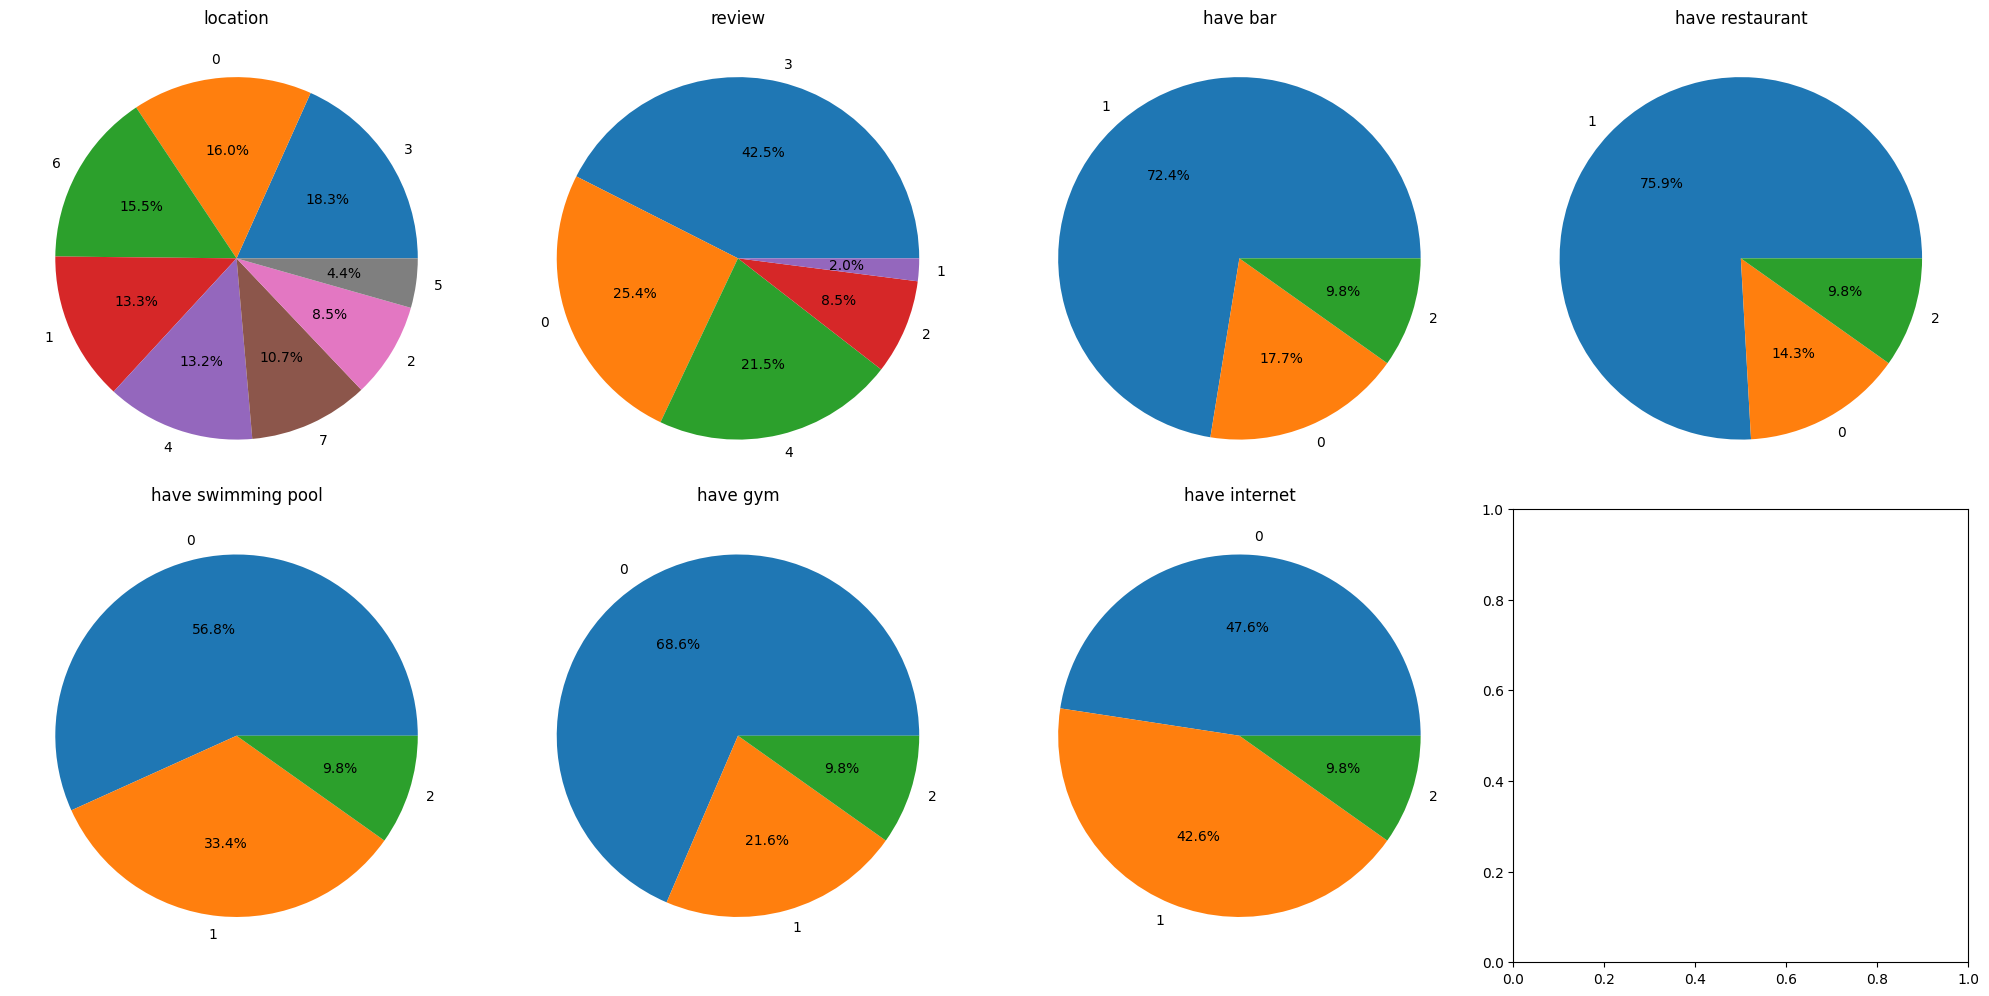

In [86]:
# create figure with subplots
fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (20,10))
axs = axs.flatten()

# create Pie Chart for each categorical variable
for i, var in enumerate(categoric):
  counts = eda_df[var].value_counts()
  labels = counts.index.tolist()
  values = counts.values.tolist()
  axs[i].pie(values, labels=labels, autopct='%1.1f%%')
  axs[i].set_title(var)

# adjust spacing between subplots
fig.tight_layout()

# show plot
plt.show()

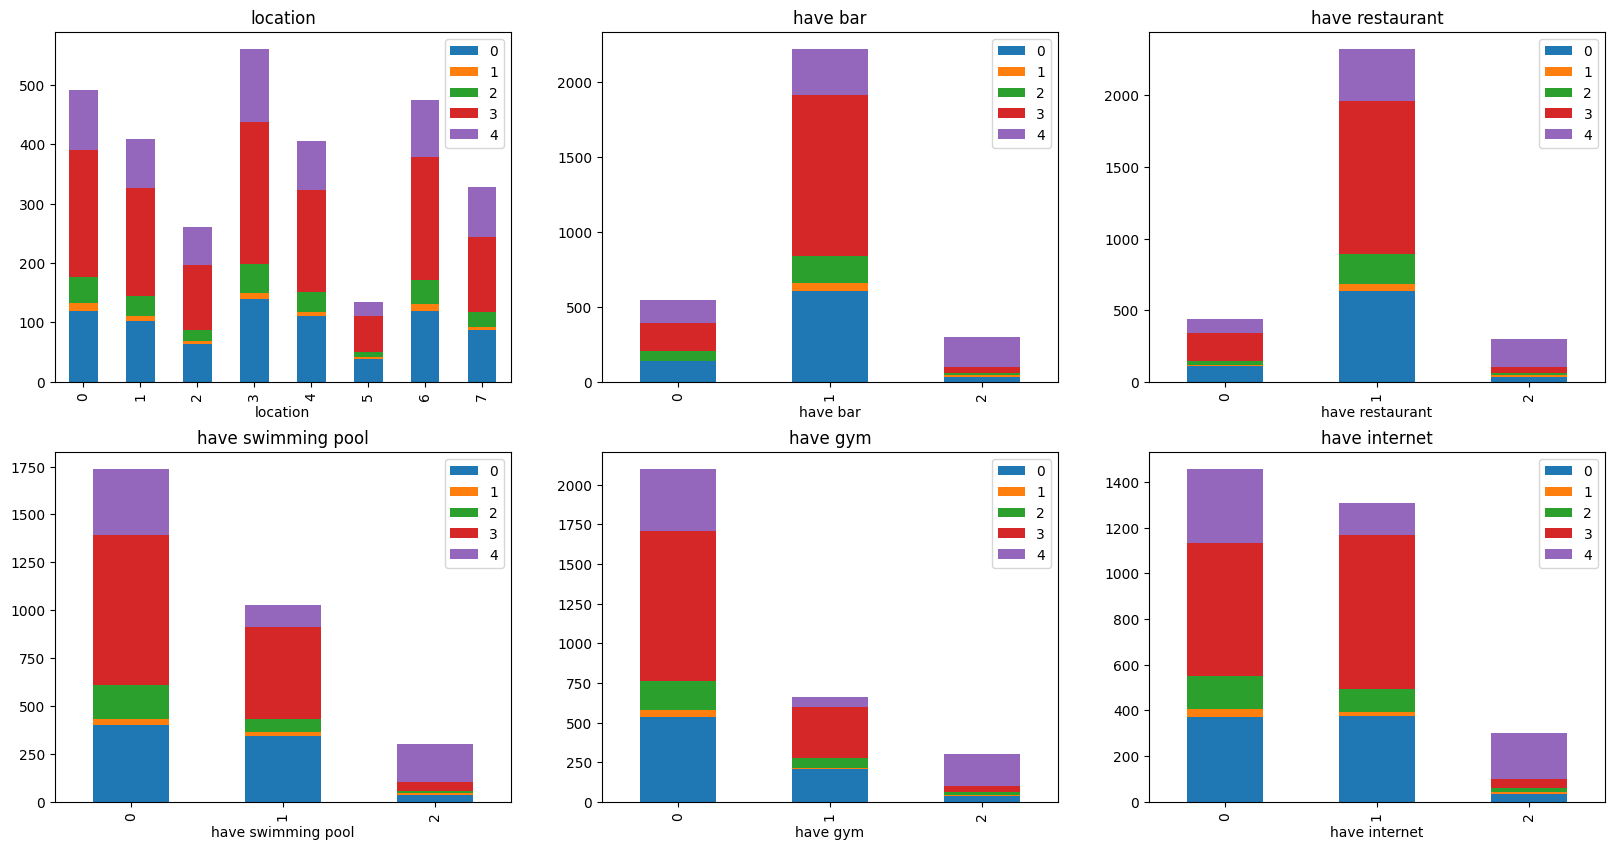

In [87]:
# Visualize Categorical Data
# Initialize subplot
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
x_position = 0
y_position = 0

for i in categoric:
    if i == 'review':
        continue  # Skip the 'review' variable
    if y_position == 3:
        y_position = 0
        x_position += 1
    df_plot = eda_df.groupby(['review', i]).size().reset_index().pivot(columns='review', index=i, values=0)
    ax = df_plot.plot(kind='bar', stacked=True, ax=axes[x_position, y_position])
    ax.set_title(i)
    plt.xticks(rotation=90)
    ax.legend(loc='upper right')
    y_position += 1

plt.show()

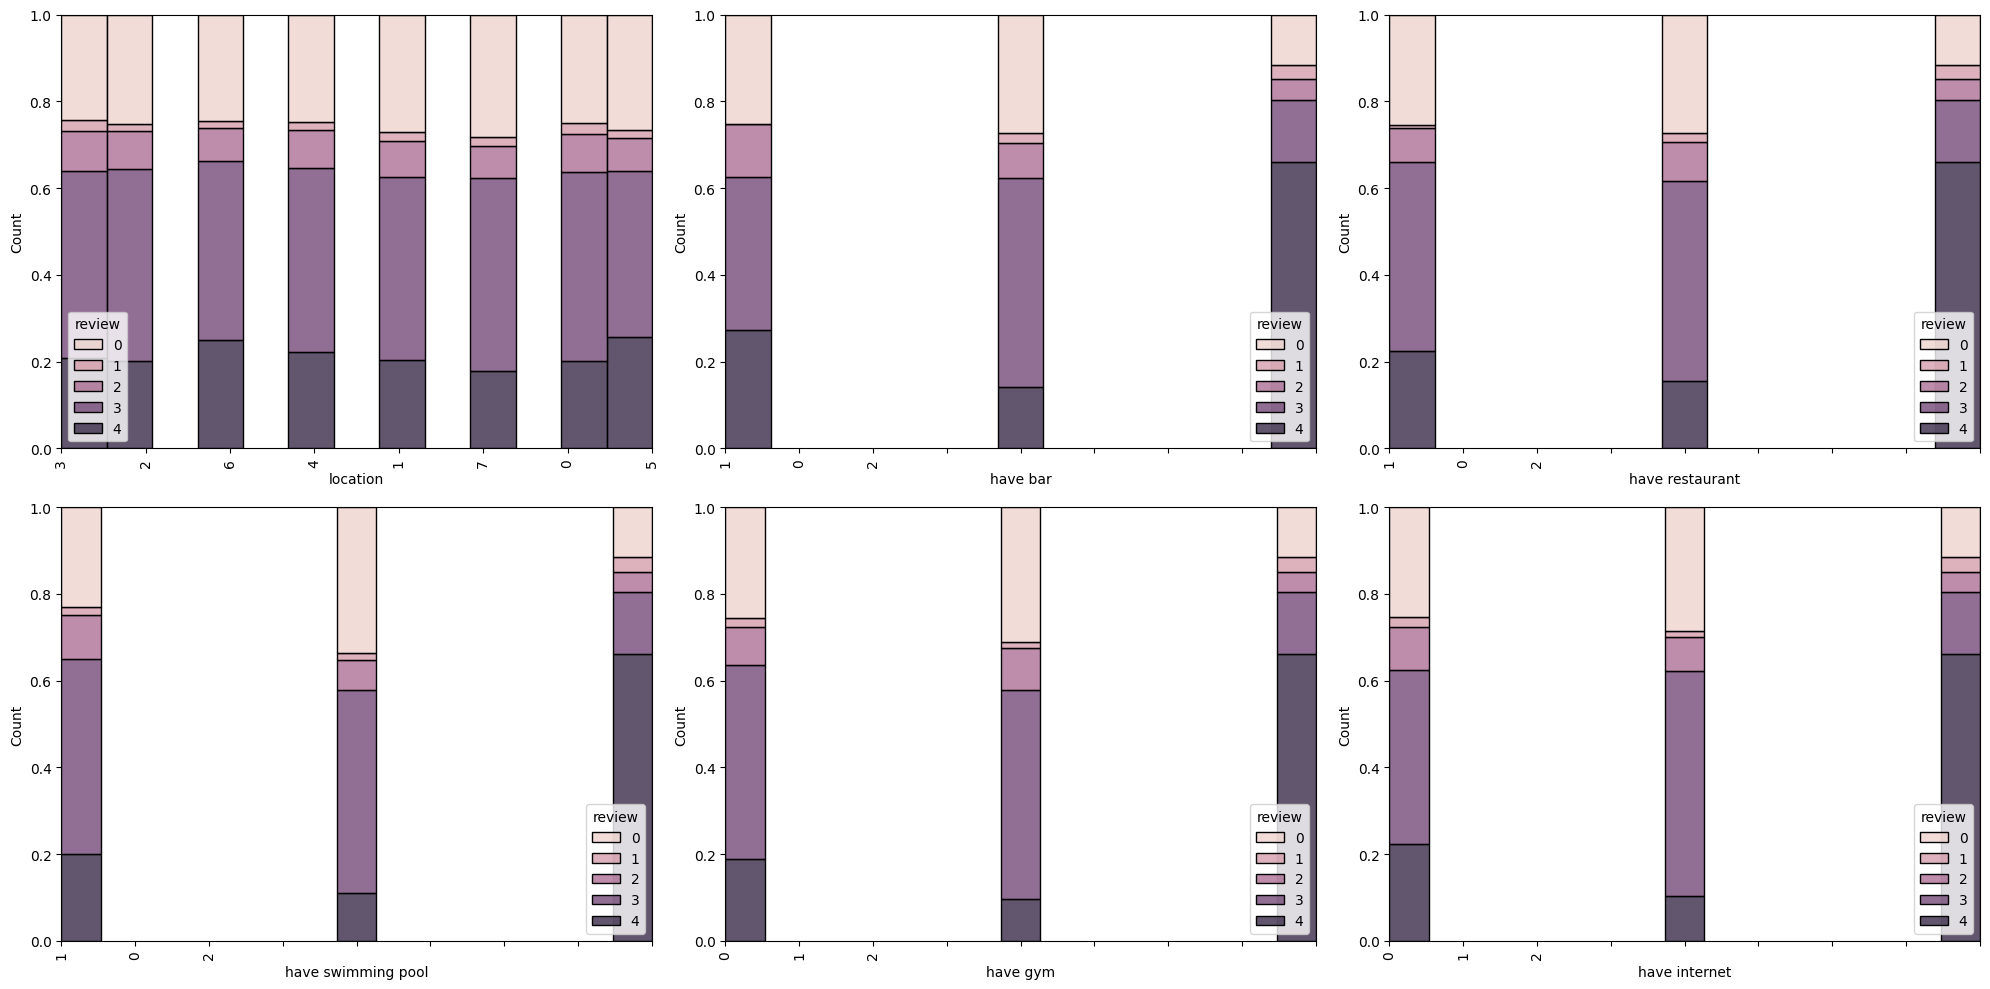

In [88]:
# create figure with subplots
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (20,10))
axs = axs.flatten()

# create histplot for each categorical variable
cat = ['location', 'have bar', 'have restaurant', 'have swimming pool', 'have gym', 'have internet']
for i, var in enumerate(cat):
  sns.histplot(x = var, hue = 'review', data = eda_df, ax=axs[i], multiple = 'fill', kde = False)
  axs[i].set_xticklabels(eda_df[var].unique(), rotation = 90)
  axs[i].set_xlabel(var)

# adjust spacing between subplots
fig.tight_layout()

# show plot
plt.show()

In [89]:
# Membuat grafik distribusi harga hotel dengan review
fig=px.histogram(eda_df, x='Price', color='review', opacity=0.7, barmode='overlay',
                 histnorm='probability density', marginal='box', 
                 title="Distribution of Hotel Price by Review Category",
                 color_discrete_sequence=['#B14B51','#B7A294']) 
fig.update_layout(font_color="#303030", xaxis_title='Hotel Price, $',
                  yaxis=dict(title='Probability Density', gridcolor='#EAEAEA', zerolinecolor='#EAEAEA'),
                  legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1, title=""))
fig.update_xaxes(showgrid=False, zerolinecolor='#EAEAEA')
fig.show()

In [90]:
# Membuat grafik harga hotel dengan lokasi dan review
plot_df = eda_df.groupby(['location','review'])['Price'].mean()
plot_df = plot_df.rename('Price').reset_index()
fig = px.bar(plot_df, x='location', y='Price', color='review', height=800,
             title="Average Hotel Price by Location and Review",
             #color_discrete_map={'0': '#BFC5DA','1': '#5D6A92', '2': '#808080', '3': '#800080'}, 
             facet_row='review', text='Price', opacity=0.85, barmode='group')
fig.update_traces(texttemplate='$%{text:,.0f}', textposition='outside', 
                  marker_line=dict(width=1, color='#303030'))
fig.layout.yaxis2.update(matches=None)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_xaxes(title="location", row=1)
fig.update_yaxes(title="Hotel Price, $",  gridcolor='#E3E3E3', zeroline=True, zerolinewidth=2, 
                 showgrid=False, zerolinecolor='#E5E5EA',
                 showline=True, linecolor='#E5E5EA', linewidth=2)
fig.update_layout(font_color="#303030", paper_bgcolor="white", plot_bgcolor="white",
                  bargroupgap=0.05, bargap=0.2,
                  legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1, title=""))
fig.show()

In [91]:
num_loc = master_df['location'].value_counts().sort_values(ascending=False)[0:20]
num_loc.name = 'Count'
num_loc.index.name = 'Location'

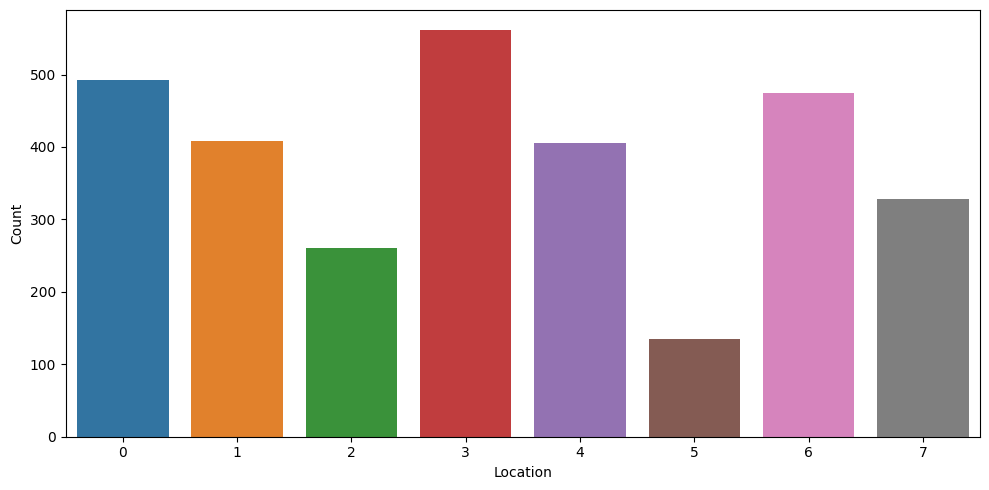

In [92]:
fig = plt.figure(figsize=(10,5))
sns.barplot(x=num_loc.index,y=num_loc)
plt.tight_layout()

In [93]:
# draw a boxen of a categorical variable along with
# how it effects the target variable which is in this case 'price'
def draw_cate_vs_target(df, feature):
    plt.grid(True)
    ax = sns.boxenplot(data=df, x=feature, y='Price')
    ax.set_title(f'{feature} vs price', fontdict={'fontsize': 18})

# draw the countplot of a categorical variable
def draw_cate_countplot(df, feature):
    plt.grid(True)
    ax = sns.countplot(x=df[feature])
    ax.set_title(f'{feature}\'s count', fontdict={'fontsize': 18})

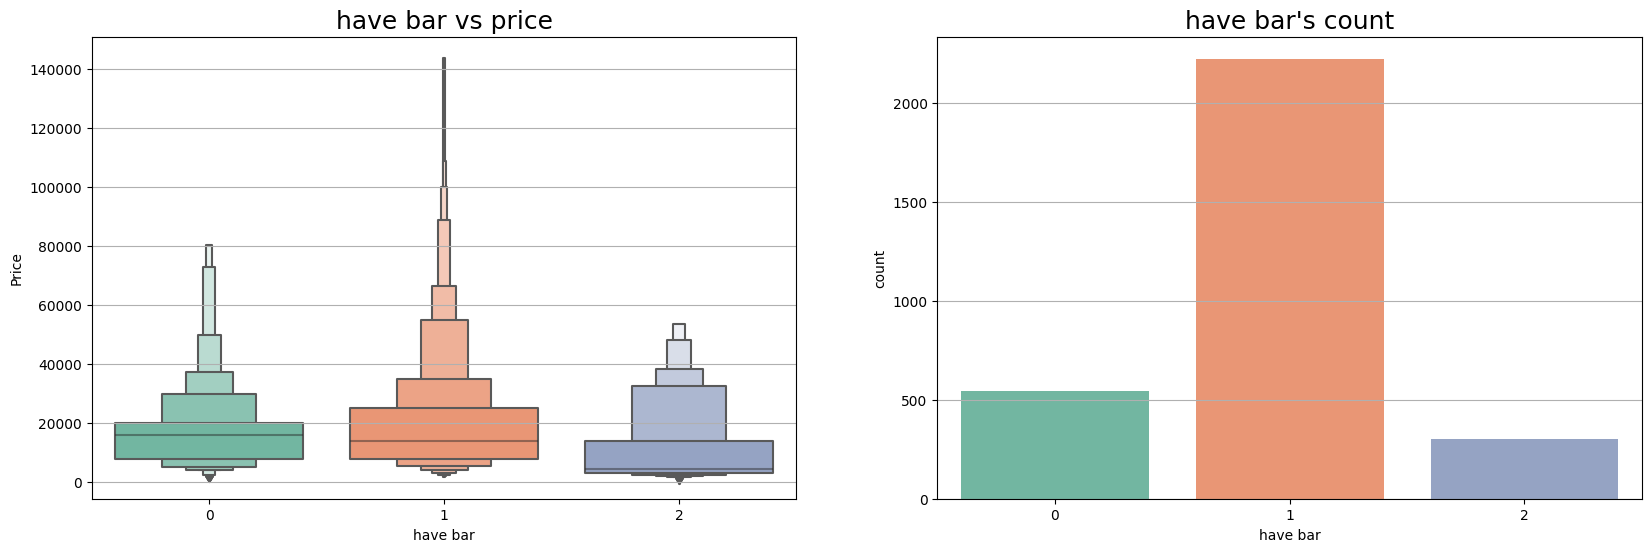

In [94]:
# draw a boxen plot of bar vs price
plt.figure(figsize=(20, 6))
sns.set_palette('Set2')
plt.subplot(1, 2, 1)
draw_cate_vs_target(master_df, categoric[2])

plt.subplot(1, 2, 2)
draw_cate_countplot(master_df, categoric[2])
plt.show()  

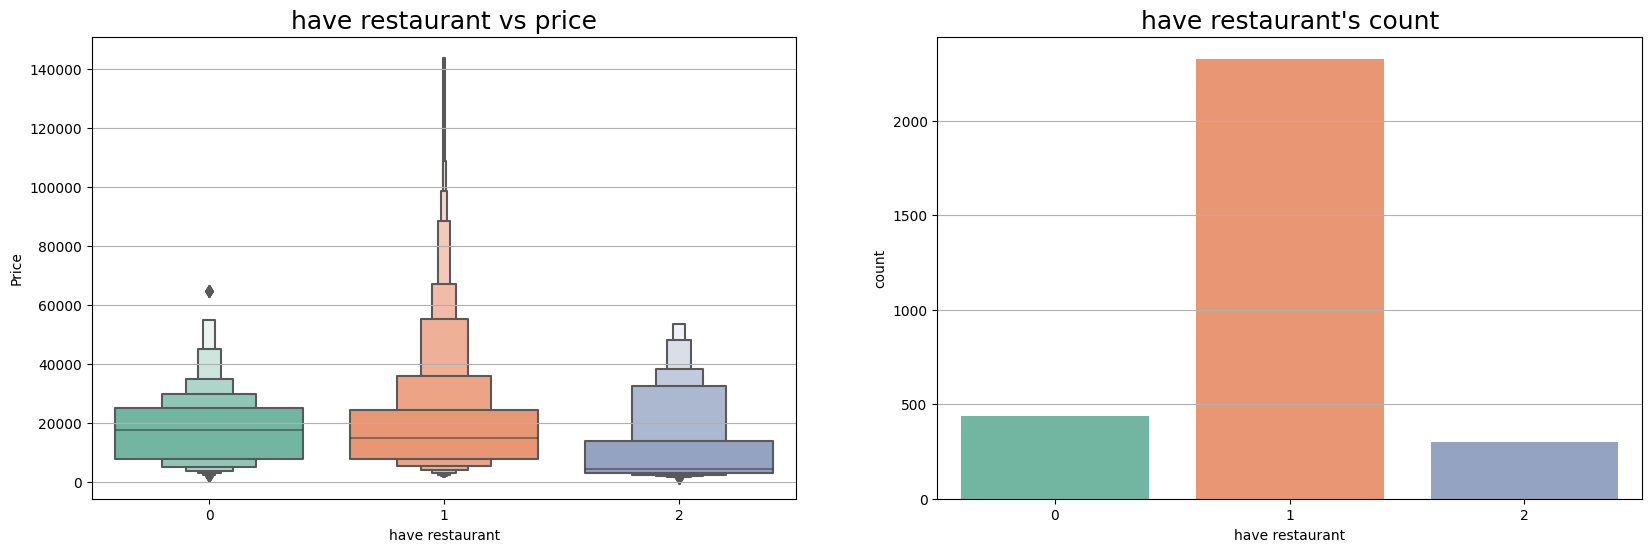

In [95]:
# draw a boxen plot of restaurant vs price
plt.figure(figsize=(20, 6))
sns.set_palette('Set2')
plt.subplot(1, 2, 1)
draw_cate_vs_target(master_df, categoric[3])

plt.subplot(1, 2, 2)
draw_cate_countplot(master_df, categoric[3])
plt.show()  

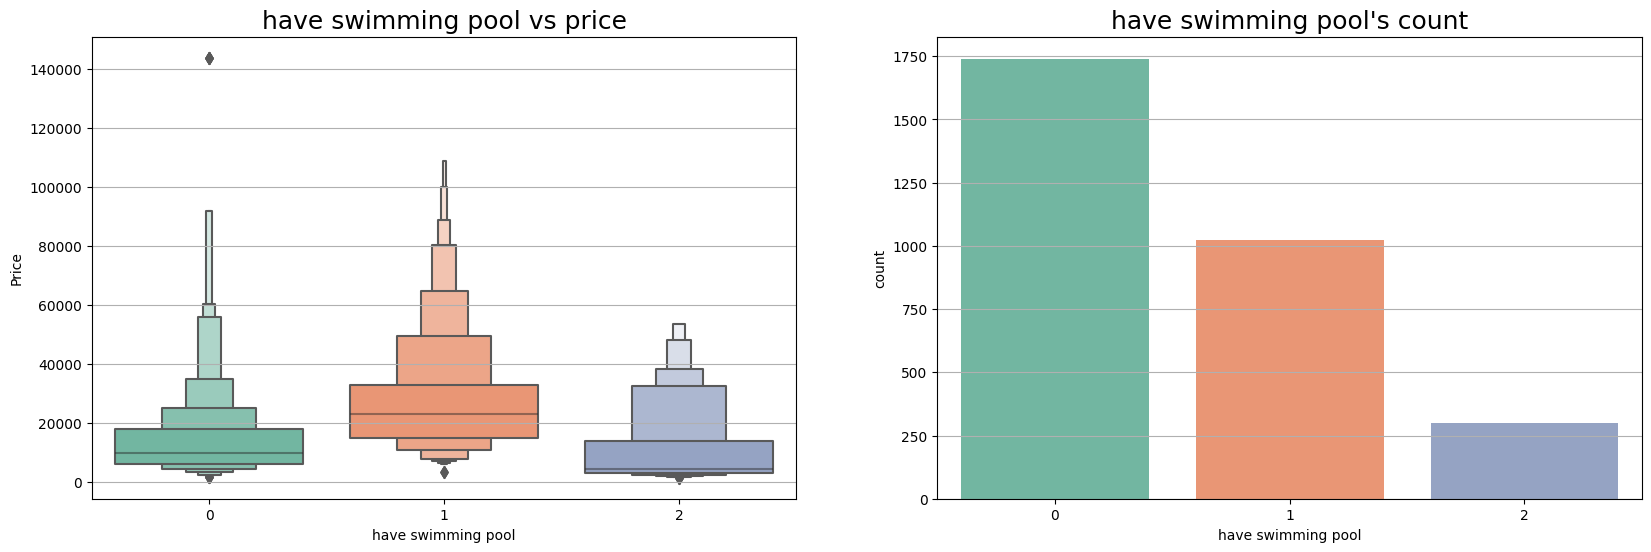

In [96]:
# draw a boxen plot of swimming pool vs price
plt.figure(figsize=(20, 6))
sns.set_palette('Set2')
plt.subplot(1, 2, 1)
draw_cate_vs_target(master_df, categoric[4])

plt.subplot(1, 2, 2)
draw_cate_countplot(master_df, categoric[4])
plt.show()  

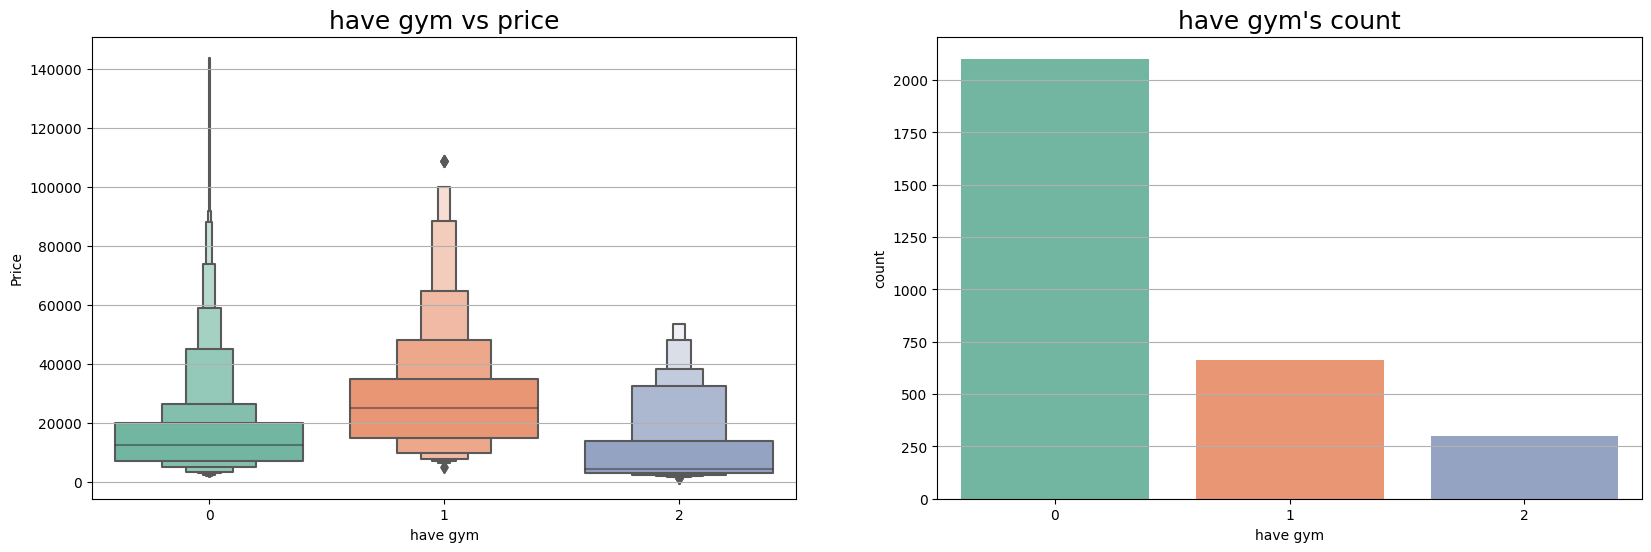

In [97]:
# draw a boxen plot of gym vs price
plt.figure(figsize=(20, 6))
sns.set_palette('Set2')
plt.subplot(1, 2, 1)
draw_cate_vs_target(master_df, categoric[5])

plt.subplot(1, 2, 2)
draw_cate_countplot(master_df, categoric[5])
plt.show()  

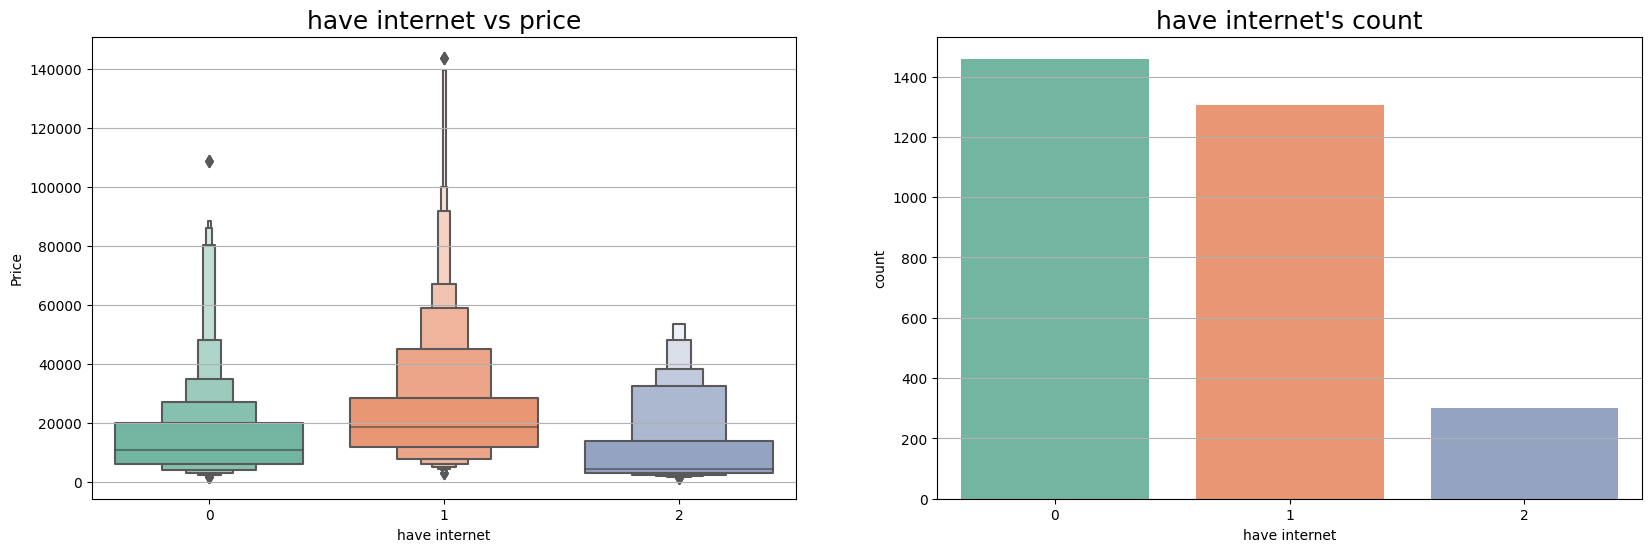

In [98]:
# draw a boxen plot of internet vs price
plt.figure(figsize=(20, 6))
sns.set_palette('Set2')
plt.subplot(1, 2, 1)
draw_cate_vs_target(master_df, categoric[6])

plt.subplot(1, 2, 2)
draw_cate_countplot(master_df, categoric[6])
plt.show()  

# Numerical Data

In [99]:
# Menunjukan statistika deskriptif dari variabel numerik di dataset
master_df.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,3066.00,7.14,1.40,2.00,6.40,7.28,8.00,10.00
location,3066.00,3.28,2.32,0.00,1.00,3.00,6.00,7.00
Price,3066.00,18627.11,17558.43,1500.00,7140.00,14000.00,24000.00,143802.00
review,3066.00,2.33,1.49,0.00,0.00,3.00,3.00,4.00
total reviews,3066.00,17.48,33.09,1.00,3.00,7.00,19.00,351.00
have bar,3066.00,0.92,0.52,0.00,1.00,1.00,1.00,2.00
have restaurant,3066.00,0.96,0.49,0.00,1.00,1.00,1.00,2.00
have swimming pool,3066.00,0.53,0.67,0.00,0.00,0.00,1.00,2.00
have gym,3066.00,0.41,0.66,0.00,0.00,0.00,1.00,2.00
have internet,3066.00,0.62,0.66,0.00,0.00,1.00,1.00,2.00


In [100]:
# get list of numerical variables
numeric = ['rating', 'total reviews', 'Price']

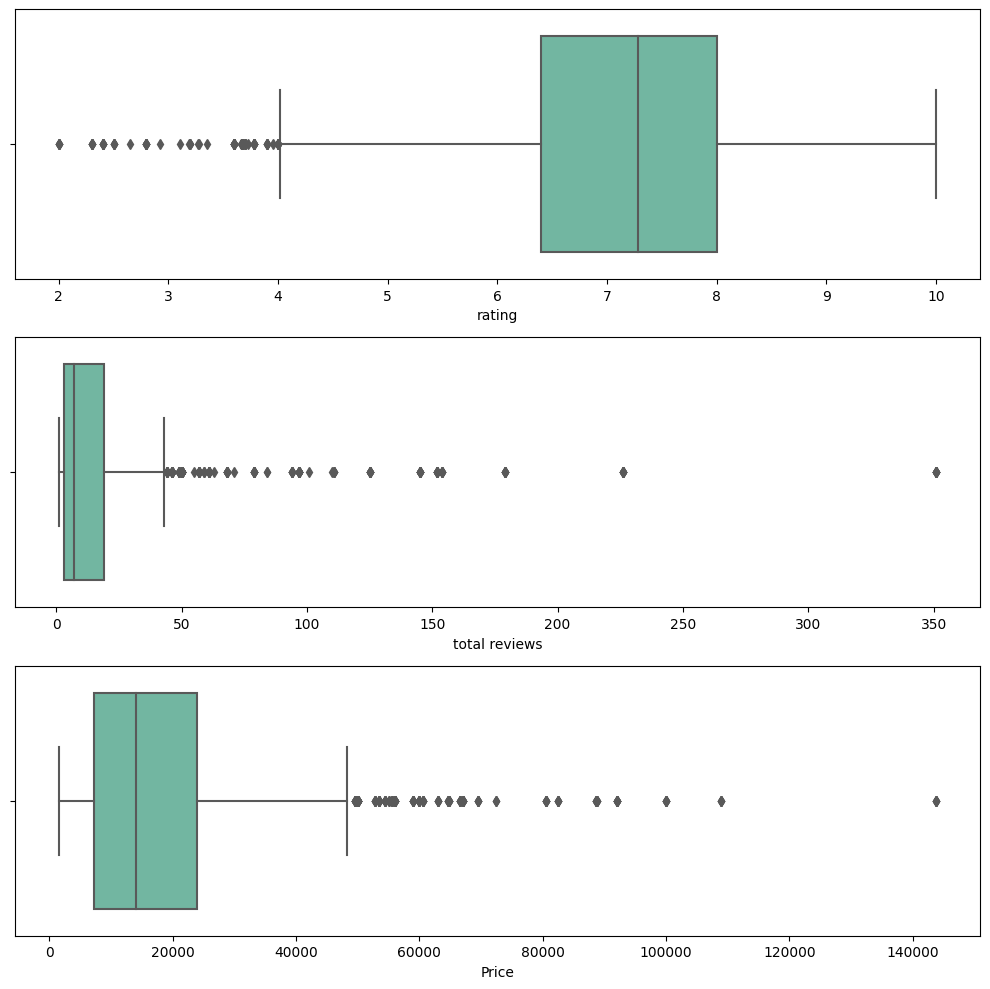

In [101]:
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = (10,10))
axs = axs.flatten()

# create boxplot for each numerical variable
for i, var in enumerate(numeric):
  sns.boxplot(x = var, data = master_df, ax=axs[i])

# adjust spacing between subplots
fig.tight_layout()

# show plot
plt.show()

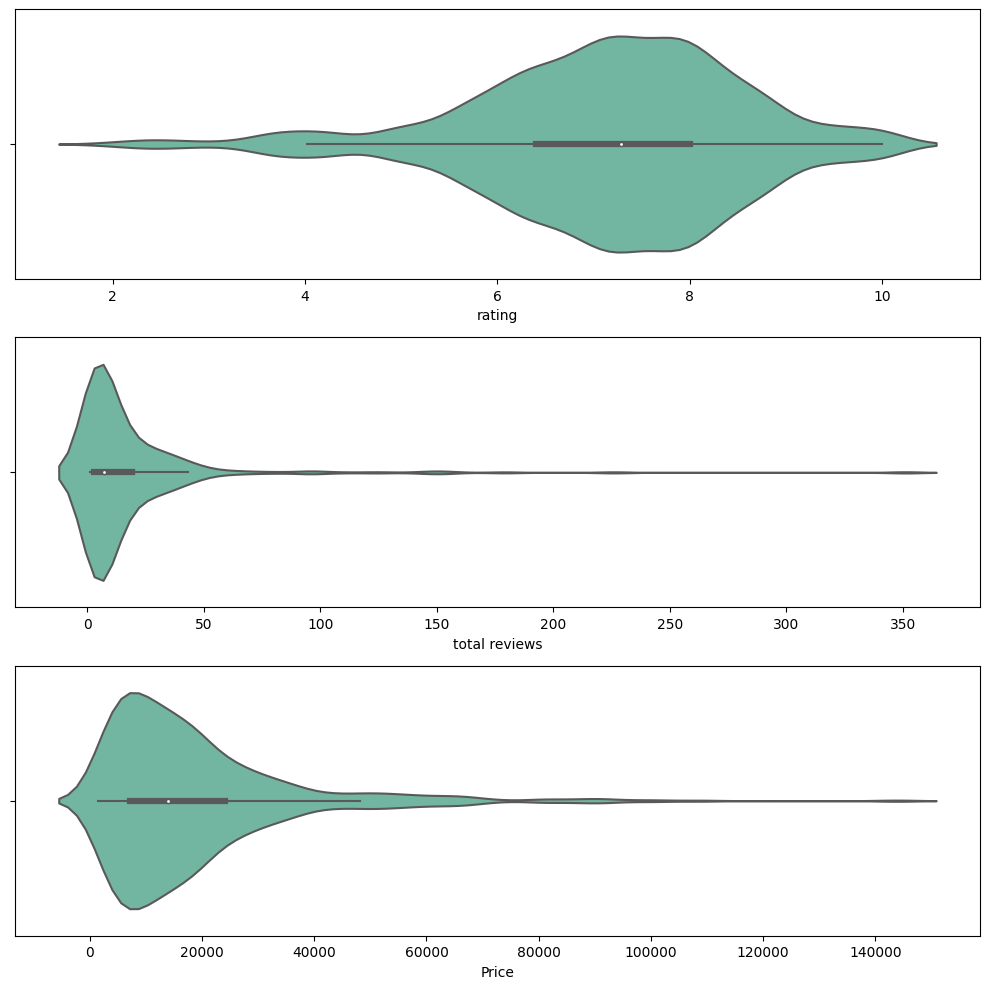

In [102]:
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = (10,10))
axs = axs.flatten()

# create boxplot for each numerical variable
for i, var in enumerate(numeric):
  sns.violinplot(x = var, data = master_df, ax=axs[i])

# adjust spacing between subplots
fig.tight_layout()

# show plot
plt.show()

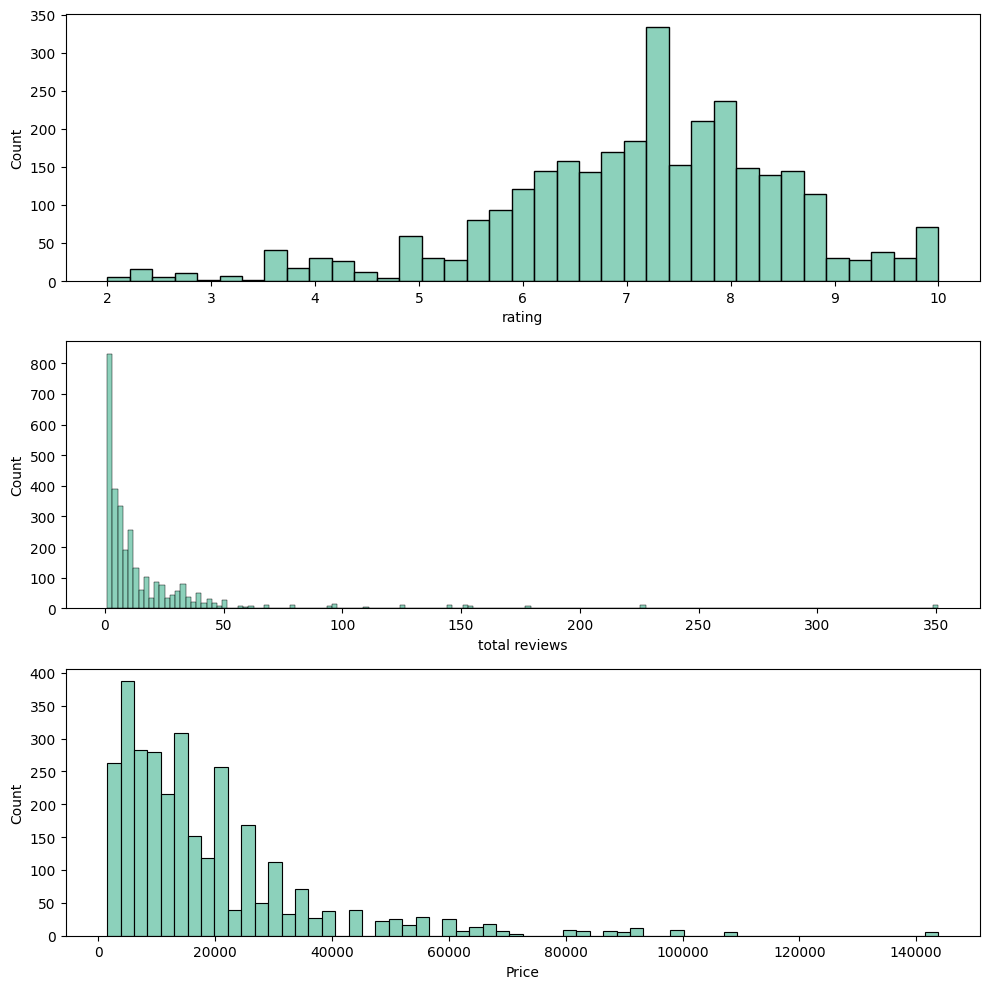

In [103]:
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = (10,10))
axs = axs.flatten()

# create boxplot for each numerical variable
for i, var in enumerate(numeric):
  sns.histplot(x = var, data = master_df, ax=axs[i])

# adjust spacing between subplots
fig.tight_layout()

# show plot
plt.show()

In [104]:
def bivariate_analysis(x):
  plt.figure(figsize=(8,4))
  ax = sns.regplot(x=x, y='Price',data=master_df)
  ax.set_title("Price vs "+x, fontsize=15)
  ax.set_xlabel(x, fontsize=10)
  ax.set_ylabel('Price', fontsize=10)
  plt.locator_params(axis='x', nbins=10)

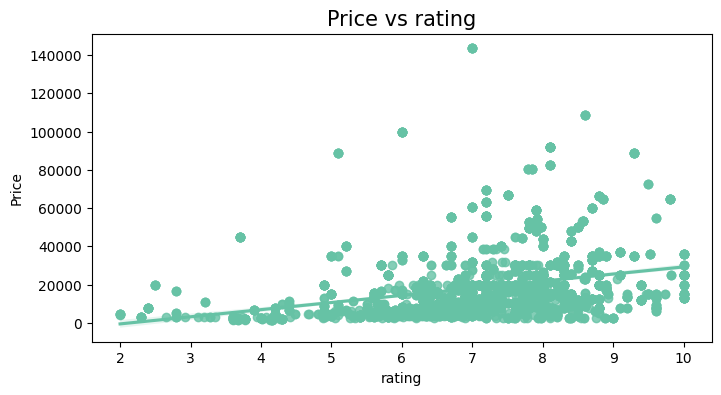

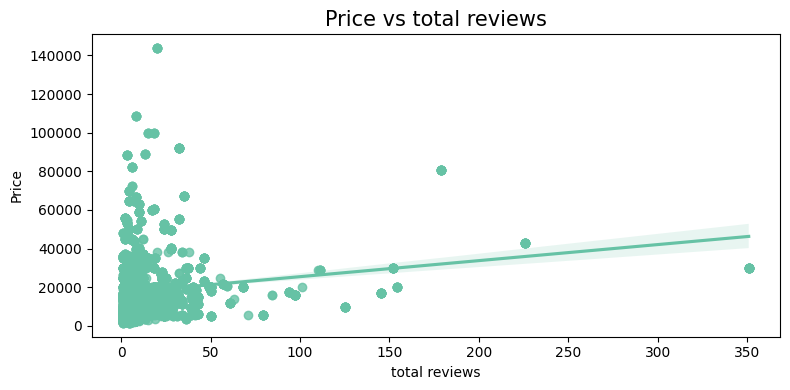

In [105]:
for x in numeric:
  if x == 'Price':
    continue  # Skip the 'review' variable
  bivariate_analysis(x)
plt.tight_layout()

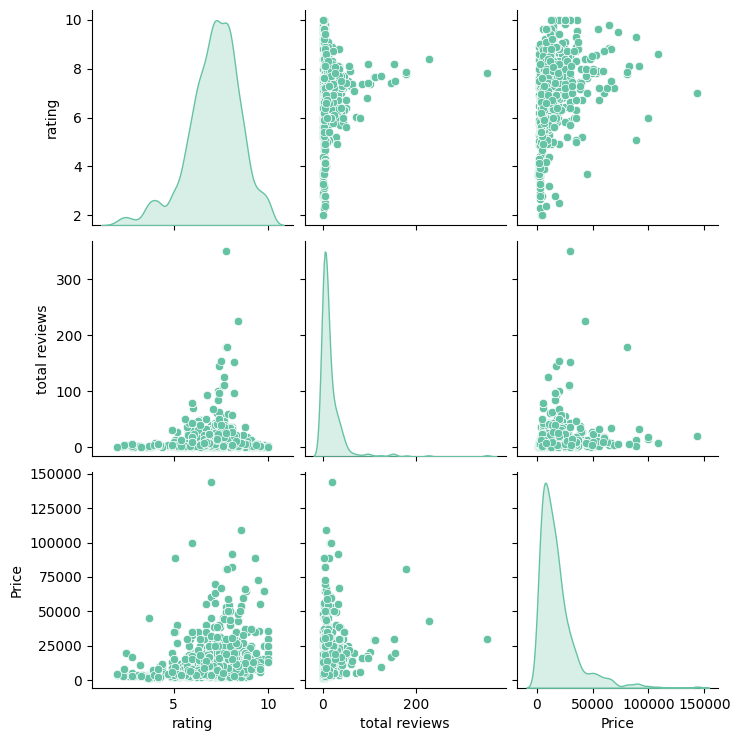

In [106]:
sns.pairplot(master_df[numeric],diag_kind='kde')

Text(0.5, 1.0, 'Hotel Price vs Rating')

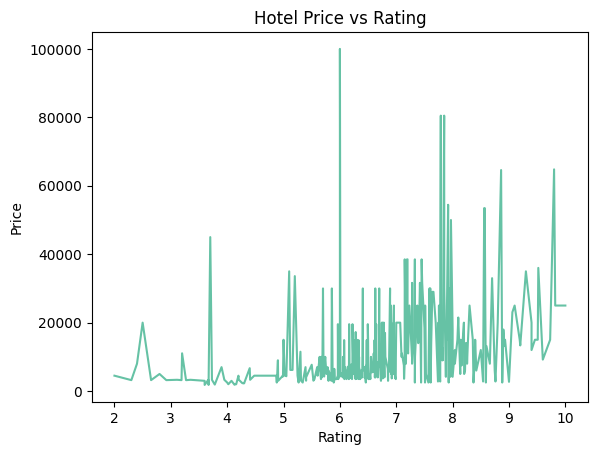

In [107]:
eda_df.groupby('rating')['Price'].median().plot()
plt.xlabel('Rating')
plt.ylabel('Price')
plt.title('Hotel Price vs Rating')

# **Modelling**

# Train Test Split

In [108]:
# Drop the 'Price' column to prepare data for splitting
X = master_df.drop(columns=['Price'])
# Get the target variable
y = master_df['Price']

In [109]:
# Split data into training, validation and test sets, ensuring the class distribution is maintained
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter Tuning using Optuna

In [ ]:
RANDOM_SEED = 48

# 10-fold CV
kfolds = KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score} \nOptimized parameters: {params}")
    return params

# Ridge Regression

In [ ]:
def ridge_objective(trial):

    _alpha = trial.suggest_float("alpha", 0.1, 20)
    ridge = Ridge(alpha=_alpha, random_state=RANDOM_SEED)
    score = cross_val_score(ridge,X_train,y_train, cv=kfolds, scoring="neg_root_mean_squared_error").mean()
    return score

ridge_params = tune(ridge_objective)

# Best score: -0.13586760243668033 
# ridge_params = {'alpha': 19.997759851201025}

[I 2023-05-22 05:35:42,371] A new study created in memory with name: no-name-c7e28024-994d-4eea-b3d0-348e08878659
[I 2023-05-22 05:35:42,450] Trial 0 finished with value: -16854.85661505674 and parameters: {'alpha': 15.482075439124845}. Best is trial 0 with value: -16854.85661505674.
[I 2023-05-22 05:35:42,520] Trial 1 finished with value: -16855.28606367742 and parameters: {'alpha': 1.676372371861914}. Best is trial 0 with value: -16854.85661505674.
[I 2023-05-22 05:35:42,577] Trial 2 finished with value: -16854.89082512836 and parameters: {'alpha': 11.627541677901164}. Best is trial 0 with value: -16854.85661505674.
[I 2023-05-22 05:35:42,638] Trial 3 finished with value: -16854.946969026438 and parameters: {'alpha': 9.132947566961326}. Best is trial 0 with value: -16854.85661505674.
[I 2023-05-22 05:35:42,700] Trial 4 finished with value: -16855.041818001268 and parameters: {'alpha': 6.370922681520793}. Best is trial 0 with value: -16854.85661505674.
[I 2023-05-22 05:35:42,758] Tria

Best score: -16854.856522046706 
Optimized parameters: {'alpha': 15.690424611279154}


In [ ]:
ridge = Ridge(**ridge_params, random_state=RANDOM_SEED)
ridge.fit(X_train,y_train)

Ridge(alpha=15.690424611279154, random_state=23)

In [ ]:
# Predict on the test set
y_pred_ridge = ridge.predict(X_test)

# Calculate the mean absolute error (MAE)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
print('MAE:', mae_ridge)

MAE: 10546.728954588843


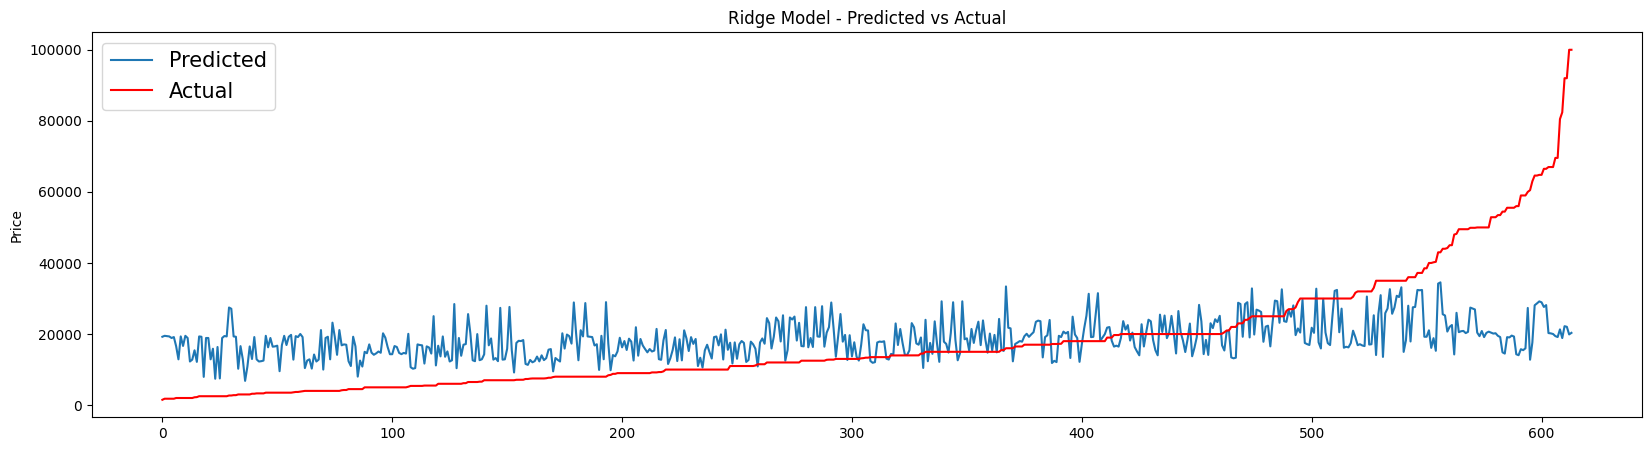

In [ ]:
g_ridge = pd.DataFrame({'actual': y_test, 'predicted': y_pred_ridge})
g_ridge = g_ridge.sort_values(by="actual").reset_index()
plt.figure(figsize=(20, 5))
plt.plot(g_ridge['predicted'], label='Predicted')
plt.plot(g_ridge['actual'], color='red', label='Actual')
plt.legend(fontsize=15)
plt.title('Ridge Model - Predicted vs Actual')
plt.ylabel('Price')
plt.show()

# Lasso Regression

In [ ]:
def lasso_objective(trial):
    _alpha = trial.suggest_float("alpha", 0.0001, 1)
    lasso = Lasso(alpha=_alpha, random_state=RANDOM_SEED)
    score = cross_val_score(lasso,X_train,y_train, cv=kfolds, scoring="neg_root_mean_squared_error").mean()
    return score

lasso_params = tune(lasso_objective)

# Best score: -0.13319435700230317 
# lasso_params = {'alpha': 0.0006224224345371836}

[I 2023-05-22 05:36:50,087] A new study created in memory with name: no-name-d4f7b2db-be6c-4b1a-91ac-f4406d87703d
[I 2023-05-22 05:36:50,156] Trial 0 finished with value: -16855.380170357217 and parameters: {'alpha': 0.8918325454066278}. Best is trial 0 with value: -16855.380170357217.
[I 2023-05-22 05:36:50,232] Trial 1 finished with value: -16855.395802086678 and parameters: {'alpha': 0.1831632134016022}. Best is trial 0 with value: -16855.380170357217.
[I 2023-05-22 05:36:50,296] Trial 2 finished with value: -16855.389528126376 and parameters: {'alpha': 0.4622124214691831}. Best is trial 0 with value: -16855.380170357217.
[I 2023-05-22 05:36:50,361] Trial 3 finished with value: -16855.397789050487 and parameters: {'alpha': 0.08910787655352277}. Best is trial 0 with value: -16855.380170357217.
[I 2023-05-22 05:36:50,433] Trial 4 finished with value: -16855.394629817332 and parameters: {'alpha': 0.2331674353209528}. Best is trial 0 with value: -16855.380170357217.
[I 2023-05-22 05:36:

Best score: -16855.377604573907 
Optimized parameters: {'alpha': 0.9999887676584366}


In [ ]:
lasso = Lasso(**lasso_params, random_state=RANDOM_SEED)
lasso.fit(X_train,y_train)

Lasso(alpha=0.9999887676584366, random_state=23)

In [ ]:
# Predict on the test set
y_pred_lasso = lasso.predict(X_test)

# Calculate the mean absolute error (MAE)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
print('MAE:', mae_lasso)

MAE: 10539.773648207567


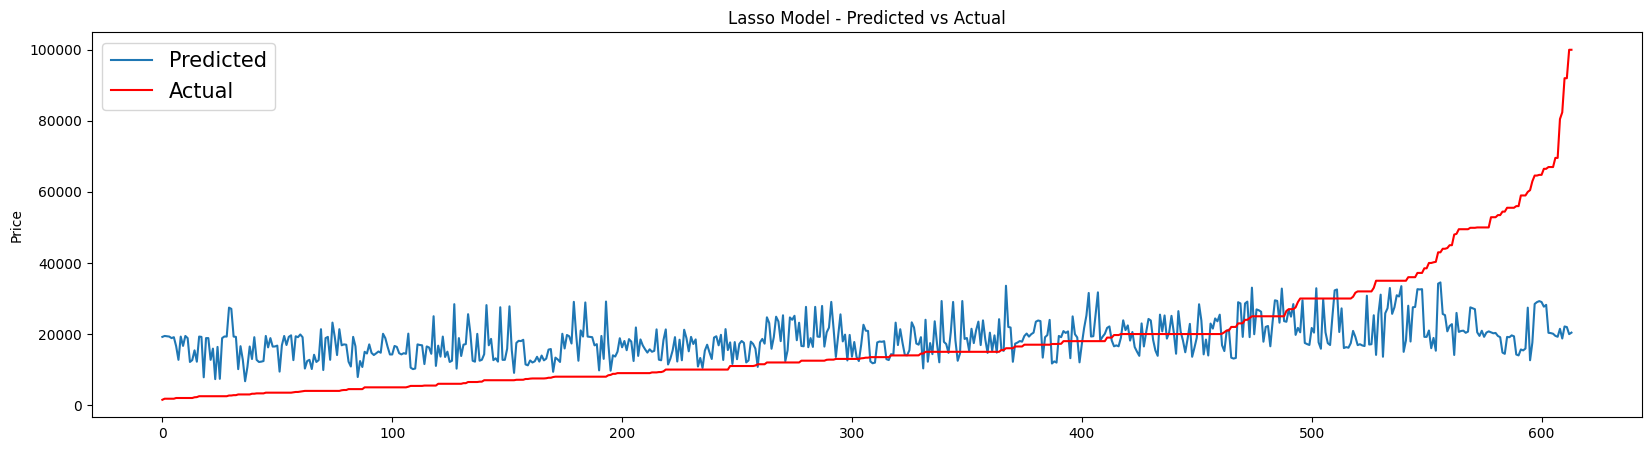

In [ ]:
g_lasso = pd.DataFrame({'actual': y_test, 'predicted': y_pred_lasso})
g_lasso = g_lasso.sort_values(by="actual").reset_index()
plt.figure(figsize=(20, 5))
plt.plot(g_lasso['predicted'], label='Predicted')
plt.plot(g_lasso['actual'], color='red', label='Actual')
plt.legend(fontsize=15)
plt.title('Lasso Model - Predicted vs Actual')
plt.ylabel('Price')
plt.show()

# Gradient Boosting Regressor

In [ ]:
def gbr_objective(trial):
    _n_estimators = trial.suggest_int("n_estimators", 50, 2000)
    _learning_rate = trial.suggest_float("learning_rate", 0.01, 1)
    _max_depth = trial.suggest_int("max_depth", 1, 20)
    _min_samp_split = trial.suggest_int("min_samples_split", 2, 20)
    _min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 20)
    _max_features = trial.suggest_int("max_features", 10, 50)

    gbr = GradientBoostingRegressor(
        n_estimators=_n_estimators,
        learning_rate=_learning_rate,
        max_depth=_max_depth, 
        max_features=_max_features,
        min_samples_leaf=_min_samples_leaf,
        min_samples_split=_min_samp_split,
        random_state=RANDOM_SEED)

    score = cross_val_score(gbr, X_train,y_train, cv=kfolds, scoring="neg_root_mean_squared_error").mean()
    return score

gbr_params = tune(gbr_objective)

[I 2023-05-22 05:37:26,234] A new study created in memory with name: no-name-7c72857f-2f17-4a25-b584-8f685330df96
[I 2023-05-22 05:37:30,999] Trial 0 finished with value: -9369.431945673336 and parameters: {'n_estimators': 283, 'learning_rate': 0.23578214521268645, 'max_depth': 3, 'min_samples_split': 19, 'min_samples_leaf': 8, 'max_features': 40}. Best is trial 0 with value: -9369.431945673336.
[I 2023-05-22 05:38:27,545] Trial 1 finished with value: -8507.386224279131 and parameters: {'n_estimators': 1368, 'learning_rate': 0.3546385148992298, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': 26}. Best is trial 1 with value: -8507.386224279131.
[I 2023-05-22 05:39:00,774] Trial 2 finished with value: -8476.82210384647 and parameters: {'n_estimators': 575, 'learning_rate': 0.33581942249928004, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 47}. Best is trial 2 with value: -8476.82210384647.
[I 2023-05-22 05:39:26,985] Trial

Best score: -7150.4830724057565 
Optimized parameters: {'n_estimators': 1767, 'learning_rate': 0.4019472905553033, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 45}


In [ ]:
gbr = GradientBoostingRegressor(random_state=RANDOM_SEED, **gbr_params)
gbr.fit(X_train,y_train)

GradientBoostingRegressor(learning_rate=0.4019472905553033, max_features=45,
                          min_samples_leaf=5, min_samples_split=3,
                          n_estimators=1767, random_state=23)

In [ ]:
# Predict on the test set
y_pred_gbr = gbr.predict(X_test)

# Calculate the mean absolute error (MAE)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
print('MAE:', mae_gbr)

MAE: 3237.404431413303


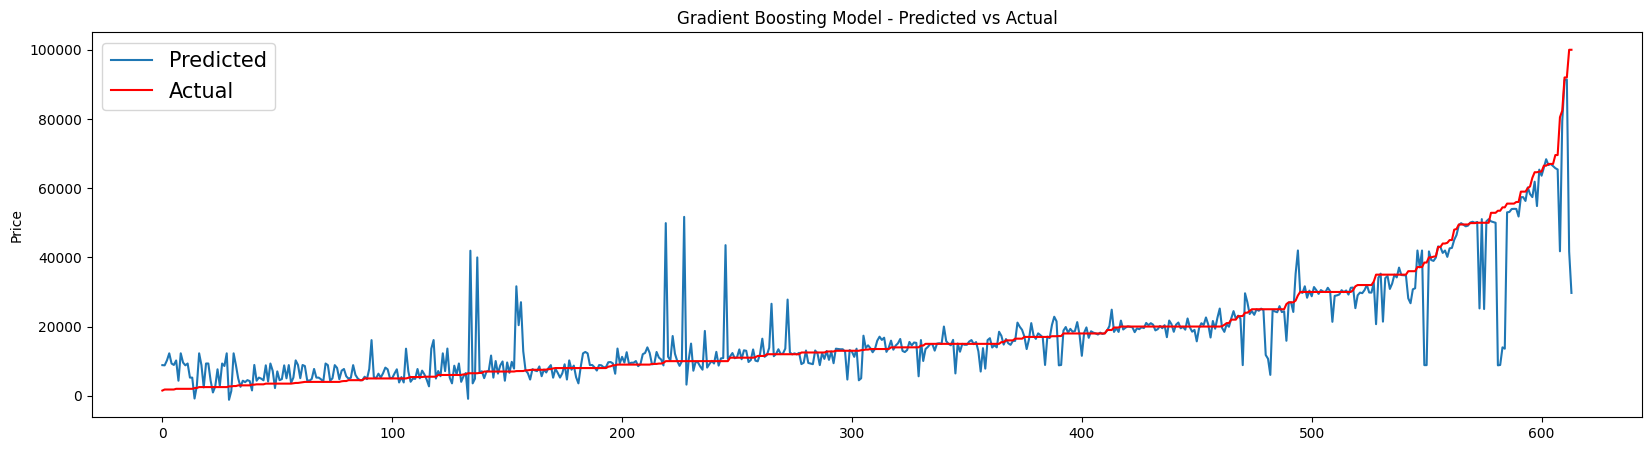

In [ ]:
g_gbr = pd.DataFrame({'actual': y_test, 'predicted': y_pred_gbr})
g_gbr = g_gbr.sort_values(by="actual").reset_index()
plt.figure(figsize=(20, 5))
plt.plot(g_gbr['predicted'], label='Predicted')
plt.plot(g_gbr['actual'], color='red', label='Actual')
plt.legend(fontsize=15)
plt.title('Gradient Boosting Model - Predicted vs Actual')
plt.ylabel('Price')
plt.show()

# XGBRegressor

In [ ]:
def xgb_objective(trial):
    _n_estimators = trial.suggest_int("n_estimators", 50, 2000)
    _max_depth = trial.suggest_int("max_depth", 1, 20)
    _learning_rate = trial.suggest_float("learning_rate", 0.01, 1)
    _gamma = trial.suggest_float("gamma", 0.01, 1)
    _min_child_weight = trial.suggest_float("min_child_weight", 0.1, 10)
    _subsample = trial.suggest_float('subsample', 0.01, 1)
    _reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10)
    _reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10)

    
    xgbr = xgb.XGBRegressor(
        n_estimators=_n_estimators,
        max_depth=_max_depth, 
        learning_rate=_learning_rate,
        gamma=_gamma,
        min_child_weight=_min_child_weight,
        subsample=_subsample,
        reg_alpha=_reg_alpha,
        reg_lambda=_reg_lambda,
        random_state=RANDOM_SEED)
    
    score = cross_val_score(xgbr, X_train,y_train, cv=kfolds, scoring="neg_root_mean_squared_error").mean()
    return score

xgb_params = tune(xgb_objective)

In [ ]:
xgbr = xgb.XGBRegressor(random_state=RANDOM_SEED, **xgb_params)
xgbr.fit(X_train,y_train)

In [ ]:
# Predict on the test set
y_pred_xgbr = xgbr.predict(X_test)

# Calculate the mean absolute error (MAE)
mae_xgbr = mean_absolute_error(y_test, y_pred_xgbr)
print('MAE:', mae_xgbr)

In [ ]:
g_xgbr = pd.DataFrame({'actual' : y_test,'predicted': y_pred_xgbr})
g_xgbr = g_xgbr.sort_values(by="actual").reset_index()
plt.figure(figsize = (20,5))
plt.plot(g_xgbr['predicted'])
plt.plot(g_xgbr['actual'], color = 'red')
plt.ylim(0,1000)
plt.legend(['Predicted','Actual'],fontsize = 15)
plt.title('XGBoost Model')
plt.ylabel('Price')
plt.show()

# LGBMRegressor

In [ ]:
import lightgbm as lgb

def lgb_objective(trial):
    _num_leaves = trial.suggest_int("num_leaves", 50, 100)
    _max_depth = trial.suggest_int("max_depth", 1, 20)
    _learning_rate = trial.suggest_float("learning_rate", 0.01, 1)
    _n_estimators = trial.suggest_int("n_estimators", 50, 2000)
    _min_child_weight = trial.suggest_float("min_child_weight", 0.1, 10)
    _reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10)
    _reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10)
    _subsample = trial.suggest_float('subsample', 0.01, 1)


    
    lgbr = lgb.LGBMRegressor(objective='regression',
                             num_leaves=_num_leaves,
                             max_depth=_max_depth,
                             learning_rate=_learning_rate,
                             n_estimators=_n_estimators,
                             min_child_weight=_min_child_weight,
                             subsample=_subsample,
                             reg_alpha=_reg_alpha,
                             reg_lambda=_reg_lambda,
                             random_state=RANDOM_SEED)
    

    score = cross_val_score(lgbr, X_train,y_train, cv=kfolds, scoring="neg_root_mean_squared_error").mean()
    return score

lgb_params = tune(lgb_objective)

In [ ]:
lgbr = lgb.LGBMRegressor(objective='regression', random_state=RANDOM_SEED, **lgb_params)
lgbr.fit(X_train,y_train)

In [ ]:
# Predict on the test set
y_pred_lgbr = lgbr.predict(X_test)

# Calculate the mean absolute error (MAE)
mae_lgbr = mean_absolute_error(y_test, y_pred_lgbr)
print('MAE:', mae_lgbr)

In [ ]:
g_lgbr = pd.DataFrame({'actual' : y_test,'predicted': y_pred_lgbr})
g_lgbr = g_lgbr.sort_values(by="actual").reset_index()
plt.figure(figsize = (20,5))
plt.plot(g_lgbr['predicted'])
plt.plot(g_lgbr['actual'], color = 'red')
plt.ylim(0,1000)
plt.legend(['Predicted','Actual'],fontsize = 15)
plt.title('LGBM Regressor Model')
plt.ylabel('Price')
plt.show()

# LGBM Regressor

In [ ]:
import optuna
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [ ]:
def objective(trial,data=X,target=y):
    param = {
        'metric': 'mae', 
        'random_state': 48,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    model1 = LGBMRegressor(**param)  
    
    model1.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
    
    preds = model1.predict(X_test)
    
    mae = mean_absolute_error(y_test, preds)
    
    return mae

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-05-21 11:33:25,092] A new study created in memory with name: no-name-f9980f63-3830-4f97-9a89-7517e37c9876
[I 2023-05-21 11:33:42,547] Trial 0 finished with value: 7920.245943558797 and parameters: {'reg_alpha': 0.001491952255405533, 'reg_lambda': 0.0012870389213530736, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 100, 'num_leaves': 253, 'min_child_samples': 268, 'min_data_per_groups': 95}. Best is trial 0 with value: 7920.245943558797.
[I 2023-05-21 11:33:59,428] Trial 1 finished with value: 7589.702187536603 and parameters: {'reg_alpha': 6.049338190352932, 'reg_lambda': 0.06499171830708832, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.006, 'max_depth': 20, 'num_leaves': 608, 'min_child_samples': 216, 'min_data_per_groups': 99}. Best is trial 1 with value: 7589.702187536603.
[I 2023-05-21 11:34:07,213] Trial 2 finished with value: 7289.295942733921 and parameters: {'reg_alpha': 0.022480698841105574, 'reg_lambda': 7.642675545317

Number of finished trials: 50
Best trial: {'reg_alpha': 0.007630345901049224, 'reg_lambda': 0.3303700155844077, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 100, 'num_leaves': 460, 'min_child_samples': 25, 'min_data_per_groups': 40}


In [ ]:
# Define the best parameters obtained from Optuna
best_params = study.best_params
best_params['random_state'] = 48
best_params['n_estimators'] = 20000 
best_params['metric'] = 'mae'

# Initialize and fit the LGBMRegressor model with the best parameters
model1 = LGBMRegressor(**best_params)
model1.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)

# Predict on the test set
y_pred = model1.predict(X_test)

# Evaluate the model performance
mae = mean_absolute_error(y_test, y_pred)
print('MAE:', mae)

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
MAE: 3275.3980037992596


In [ ]:
g_lgb = pd.DataFrame({'actual' : y_test,'predicted': y_pred})
g_lgb = g_lgb.sort_values(by="actual").reset_index()
plt.figure(figsize = (20,5))
plt.plot(g_lgb['predicted'])
plt.plot(g_lgb['actual'], color = 'red')
plt.ylim(0,1000)
plt.legend(['Predicted','Actual'],fontsize = 15)
plt.title('LGBM Regressor Model')
plt.ylabel('Price')
plt.show()

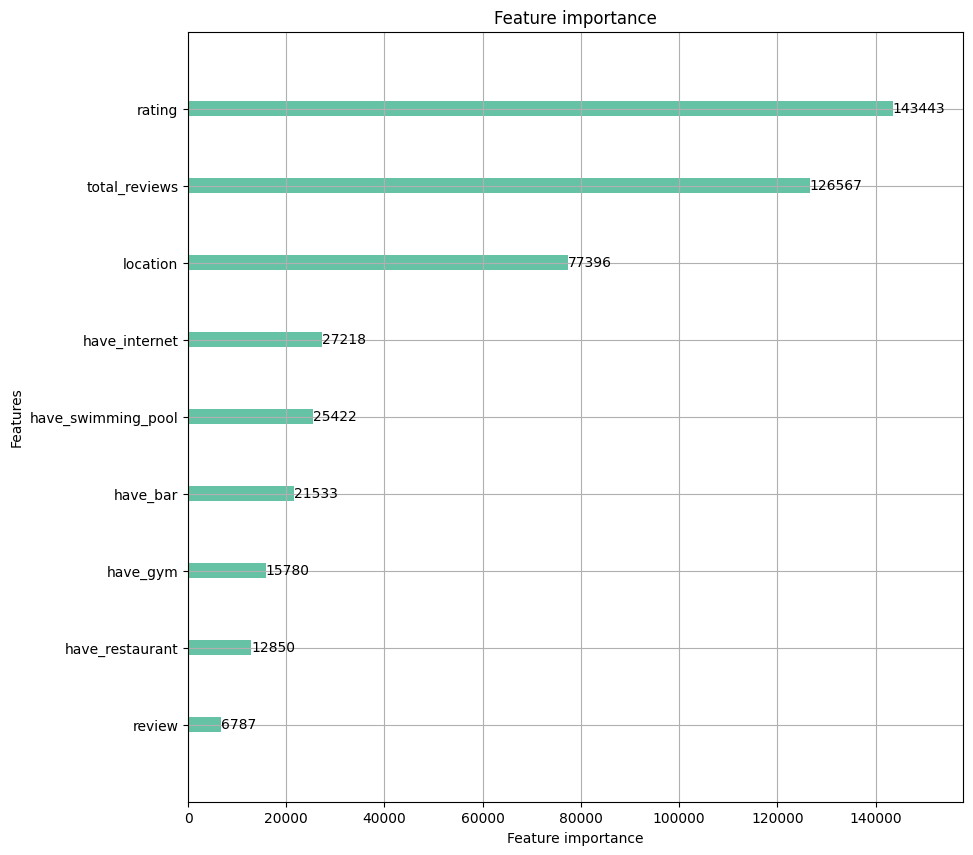

In [ ]:
from optuna.integration import lightgbm as lgb
lgb.plot_importance(model1, max_num_features=10, figsize=(10,10))
plt.show()

# Random Forest Regressor

In [110]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [111]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [112]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('MAE: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy
    
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

Model Performance
MAE: 1501.2606 degrees.
Accuracy = 80.63%.


In [113]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

Model Performance
MAE: 1419.2672 degrees.
Accuracy = 81.40%.


# **Predict Data Test_Set_Features**

In [116]:
test_df = pd.read_csv("test_feature.csv")

In [119]:
# Size Dataset
print('Size dataset:', test_df.shape)

Size dataset: (767, 4)


# Feature Engineering

In [120]:
# Change type obj to str
test_df = test_df.astype({"facilities":"str","rating":"str"})

Ubah tipe data untuk features 'facilities', 'rating' dari object ke string supaya dapat digunakan modul nltk

###**Cleaning Feature 'rating'**

In [121]:
# Download required resources from NLTK
nltk.download('punkt')

# Define a function to extract rating, review, and total reviews
def extract_info(text):
    tokens = nltk.word_tokenize(str(text))  # Convert to string
    rating = tokens[0]
    review = tokens[1:-2]
    total_reviews = tokens[-2] if len(tokens) >= 2 else None
    return rating, review, total_reviews

# Apply the function to the 'rating' column
test_df[['rating', 'review', 'total reviews']] = test_df['rating'].apply(extract_info).apply(pd.Series)

test_df

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,ID,facilities,rating,location,review,total reviews
0,0,GymrestaurantbarInternetSwimmingPools,8.0,Stokol,[ExcellentFrom],1
1,1,Poolrestaurantgyminternetbar,7.4,Hallerson,"[Very, GoodFrom]",22
2,2,BARSwimmingPoolsInternetgym,0.0,Hallerson,[FairFrom],4
3,3,gymSwimmingPoolsBARintrnetRestaurant,6.8,Andeman,"[Very, GoodFrom]",13
4,4,gymRestaurantpoolbarintrnet,0.0,Hallerson,[FairFrom],9
...,...,...,...,...,...,...
762,762,BARPoolRestaurantGym,8.1,Andeman,[ExcellentFrom],9
763,763,intrnetGympoolrestaurantBar,8.0,Wanderland,[ExcellentFrom],4
764,764,RestaurantgymintrnetBARswimmingpools,7.4,Andeman,"[Very, GoodFrom]",19
765,765,gymInternetBarpoolRestaurant,9.0,Hallerson,[ExcellentFrom],17


Pisahkan data pada feature 'rating' menjadi 3 features baru yaitu 'rating' yang berisi rating pengunjung terhadap Kyozo hotel, 'review' yaitu keseluruhan review yang diberikan pengunjung, dan 'total reviews' yaitu banyaknya pengunjung yang melakukan review.

In [122]:
# Replace NaN, empty list, and None with NaN
test_df['rating'] = test_df['rating'].replace('nan', np.nan)
test_df['review'] = test_df['review'].apply(lambda x: np.nan if len(x) == 0 else x)
test_df['total reviews'] = test_df['total reviews'].apply(lambda x: np.nan if x is None else x)

test_df

,ID,facilities,rating,location,review,total reviews
0,0,GymrestaurantbarInternetSwimmingPools,8.0,Stokol,[ExcellentFrom],1
1,1,Poolrestaurantgyminternetbar,7.4,Hallerson,"[Very, GoodFrom]",22
2,2,BARSwimmingPoolsInternetgym,0.0,Hallerson,[FairFrom],4
3,3,gymSwimmingPoolsBARintrnetRestaurant,6.8,Andeman,"[Very, GoodFrom]",13
4,4,gymRestaurantpoolbarintrnet,0.0,Hallerson,[FairFrom],9
...,...,...,...,...,...,...
762,762,BARPoolRestaurantGym,8.1,Andeman,[ExcellentFrom],9
763,763,intrnetGympoolrestaurantBar,8.0,Wanderland,[ExcellentFrom],4
764,764,RestaurantgymintrnetBARswimmingpools,7.4,Andeman,"[Very, GoodFrom]",19
765,765,gymInternetBarpoolRestaurant,9.0,Hallerson,[ExcellentFrom],17


###**Cleaning Feature 'facilities'**

In [123]:
# Define the dictionary of facilities
facilities_dict = {
    'restaurant': ['restaurant', 'food'],
    'bar': ['bar'],
    'swimming pool': ['pool', 'swimming', 'pools'],
    'gym': ['gym', 'fitness'],
    'internet': ['internet', 'intrnet']
}

# Function to separate the text into facilities based on the dictionary
def separate_facilities(text):
    separated_text = []
    for facility, keywords in facilities_dict.items():
        if any(keyword in text.lower() for keyword in keywords):
            separated_text.append(facility)
    return ', '.join(separated_text)

# Apply the separation function to the 'facilities' column
test_df['facilities'] = test_df['facilities'].apply(separate_facilities)

test_df

,ID,facilities,rating,location,review,total reviews
0,0,"restaurant, bar, swimming pool, gym, internet",8.0,Stokol,[ExcellentFrom],1
1,1,"restaurant, bar, swimming pool, gym, internet",7.4,Hallerson,"[Very, GoodFrom]",22
2,2,"bar, swimming pool, gym, internet",0.0,Hallerson,[FairFrom],4
3,3,"restaurant, bar, swimming pool, gym, internet",6.8,Andeman,"[Very, GoodFrom]",13
4,4,"restaurant, bar, swimming pool, gym, internet",0.0,Hallerson,[FairFrom],9
...,...,...,...,...,...,...
762,762,"restaurant, bar, swimming pool, gym",8.1,Andeman,[ExcellentFrom],9
763,763,"restaurant, bar, swimming pool, gym, internet",8.0,Wanderland,[ExcellentFrom],4
764,764,"restaurant, bar, swimming pool, gym, internet",7.4,Andeman,"[Very, GoodFrom]",19
765,765,"restaurant, bar, swimming pool, gym, internet",9.0,Hallerson,[ExcellentFrom],17


Bersihkan data ada feature 'facilities' dengan memisahkan fasilitas-fasilitas yang ada pada Kyozo hotel menjadi data yang terurut.

In [124]:
# Identify distinct values in the 'facilities' feature
distinct_values = test_df['facilities'].str.split(', ').explode().unique()

print(distinct_values)

['restaurant' 'bar' 'swimming pool' 'gym' 'internet']


In [125]:
# Replace empty strings with NaN
test_df['facilities'] = test_df['facilities'].replace('', np.nan)
test_df

,ID,facilities,rating,location,review,total reviews
0,0,"restaurant, bar, swimming pool, gym, internet",8.0,Stokol,[ExcellentFrom],1
1,1,"restaurant, bar, swimming pool, gym, internet",7.4,Hallerson,"[Very, GoodFrom]",22
2,2,"bar, swimming pool, gym, internet",0.0,Hallerson,[FairFrom],4
3,3,"restaurant, bar, swimming pool, gym, internet",6.8,Andeman,"[Very, GoodFrom]",13
4,4,"restaurant, bar, swimming pool, gym, internet",0.0,Hallerson,[FairFrom],9
...,...,...,...,...,...,...
762,762,"restaurant, bar, swimming pool, gym",8.1,Andeman,[ExcellentFrom],9
763,763,"restaurant, bar, swimming pool, gym, internet",8.0,Wanderland,[ExcellentFrom],4
764,764,"restaurant, bar, swimming pool, gym, internet",7.4,Andeman,"[Very, GoodFrom]",19
765,765,"restaurant, bar, swimming pool, gym, internet",9.0,Hallerson,[ExcellentFrom],17


In [126]:
# Feature engineering: 'have bar'
test_df['have bar'] = test_df['facilities'].apply(lambda x: 2 if pd.isna(x) else (1 if 'bar' in x else 0))

# Feature engineering: 'have restaurant'
test_df['have restaurant'] = test_df['facilities'].apply(lambda x: 2 if pd.isna(x) else (1 if 'restaurant' in x else 0))

# Feature engineering: 'have swimming pools'
test_df['have swimming pool'] = test_df['facilities'].apply(lambda x: 2 if pd.isna(x) else (1 if 'swimming pool' in x else 0))

# Feature engineering: 'have gym'
test_df['have gym'] = test_df['facilities'].apply(lambda x: 2 if pd.isna(x) else (1 if 'gym' in x else 0))

# Feature engineering: 'have internet'
test_df['have internet'] = test_df['facilities'].apply(lambda x: 2 if pd.isna(x) else (1 if 'internet' in x else 0))

test_df

,ID,facilities,rating,location,review,total reviews,have bar,have restaurant,have swimming pool,have gym,have internet
0,0,"restaurant, bar, swimming pool, gym, internet",8.0,Stokol,[ExcellentFrom],1,1,1,1,1,1
1,1,"restaurant, bar, swimming pool, gym, internet",7.4,Hallerson,"[Very, GoodFrom]",22,1,1,1,1,1
2,2,"bar, swimming pool, gym, internet",0.0,Hallerson,[FairFrom],4,1,0,1,1,1
3,3,"restaurant, bar, swimming pool, gym, internet",6.8,Andeman,"[Very, GoodFrom]",13,1,1,1,1,1
4,4,"restaurant, bar, swimming pool, gym, internet",0.0,Hallerson,[FairFrom],9,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
762,762,"restaurant, bar, swimming pool, gym",8.1,Andeman,[ExcellentFrom],9,1,1,1,1,0
763,763,"restaurant, bar, swimming pool, gym, internet",8.0,Wanderland,[ExcellentFrom],4,1,1,1,1,1
764,764,"restaurant, bar, swimming pool, gym, internet",7.4,Andeman,"[Very, GoodFrom]",19,1,1,1,1,1
765,765,"restaurant, bar, swimming pool, gym, internet",9.0,Hallerson,[ExcellentFrom],17,1,1,1,1,1


# Handle Missing Values

In [127]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  767 non-null    int64 
 1   facilities          767 non-null    object
 2   rating              767 non-null    object
 3   location            767 non-null    object
 4   review              767 non-null    object
 5   total reviews       767 non-null    object
 6   have bar            767 non-null    int64 
 7   have restaurant     767 non-null    int64 
 8   have swimming pool  767 non-null    int64 
 9   have gym            767 non-null    int64 
 10  have internet       767 non-null    int64 
dtypes: int64(6), object(5)
memory usage: 66.0+ KB


In [128]:
# Missing Value
print('The number of missing value on dataset:')
test_df.isna().sum()

The number of missing value on dataset:


ID                    0
facilities            0
rating                0
location              0
review                0
total reviews         0
have bar              0
have restaurant       0
have swimming pool    0
have gym              0
have internet         0
dtype: int64

In [129]:
# Check percentage of missing values
test_df.isna().sum()/len(test_df)*100

ID                   0.00
facilities           0.00
rating               0.00
location             0.00
review               0.00
total reviews        0.00
have bar             0.00
have restaurant      0.00
have swimming pool   0.00
have gym             0.00
have internet        0.00
dtype: float64

<Axes: >

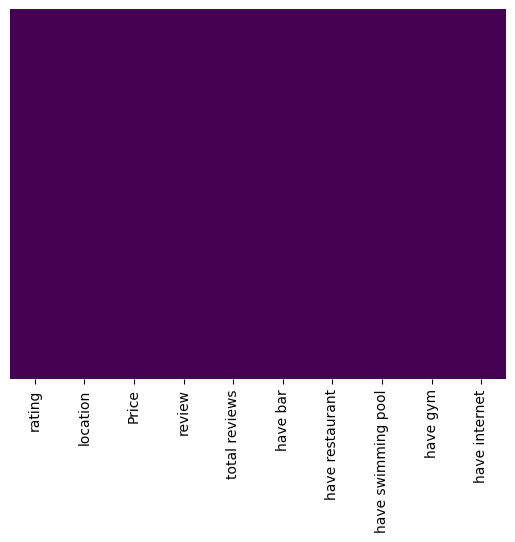

In [130]:
# Plot missing values
sns.heatmap(master_df.isna(),yticklabels=False,cbar=False,cmap='viridis')

Karena terdapat banyak missing value pada features 'facilities' dan 'rating', maka kita perlu menemukan hubungan antara missing value dengan variabel target 'price'.

# Labeling Input Data

In [135]:
le = LabelEncoder()

# Convert all elements in 'review' column to strings
test_df['review'] = test_df['review'].astype(str)

# Fit and transform the 'review' column using LabelEncoder
le.fit(test_df['review'].drop_duplicates())
test_df['review'] = le.transform(test_df['review'])

# Fit and transform the 'location' column using LabelEncoder
le.fit(test_df['location'].drop_duplicates())
test_df['location'] = le.transform(test_df['location'])

In [136]:
test_df

,ID,facilities,rating,location,review,total reviews,have bar,have restaurant,have swimming pool,have gym,have internet
0,0,"restaurant, bar, swimming pool, gym, internet",8.0,3,0,1,1,1,1,1,1
1,1,"restaurant, bar, swimming pool, gym, internet",7.4,1,3,22,1,1,1,1,1
2,2,"bar, swimming pool, gym, internet",0.0,1,1,4,1,0,1,1,1
3,3,"restaurant, bar, swimming pool, gym, internet",6.8,0,3,13,1,1,1,1,1
4,4,"restaurant, bar, swimming pool, gym, internet",0.0,1,1,9,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
762,762,"restaurant, bar, swimming pool, gym",8.1,0,0,9,1,1,1,1,0
763,763,"restaurant, bar, swimming pool, gym, internet",8.0,6,0,4,1,1,1,1,1
764,764,"restaurant, bar, swimming pool, gym, internet",7.4,0,3,19,1,1,1,1,1
765,765,"restaurant, bar, swimming pool, gym, internet",9.0,1,0,17,1,1,1,1,1


Labeling feature 'review'

*   0 - Excellent
*   1 - Fair
*   2 - God
*   3 - Very Good

Labeling feature 'location'

*   0 - Andeman
*   1 - Hallerson
*   2 - Machlessvile
*   3 - Stokol
*   4 - Uberlandia
*   5 - Ubisville
*   6 - Wanderland
*   7 - Willsmian

In [139]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  767 non-null    int64 
 1   facilities          767 non-null    object
 2   rating              767 non-null    object
 3   location            767 non-null    int64 
 4   review              767 non-null    int64 
 5   total reviews       767 non-null    object
 6   have bar            767 non-null    int64 
 7   have restaurant     767 non-null    int64 
 8   have swimming pool  767 non-null    int64 
 9   have gym            767 non-null    int64 
 10  have internet       767 non-null    int64 
dtypes: int64(8), object(3)
memory usage: 66.0+ KB


In [141]:
# Change type data
test_df = test_df.astype({"rating":"float", 'total reviews':'int'})
# Drop irelevant feature
test_df.drop(['facilities'], axis = 1, inplace = True)

# Prediction

In [143]:
# Drop the 'Price' column to prepare data for splitting
new_X = test_df.drop(columns=['ID'])

y_pred_new = rf_random.best_estimator_.predict(new_X)

In [144]:
# Create a DataFrame with the predicted 'price' values
predictions_df = pd.DataFrame({'Price': y_pred_new})
predictions_df

,Price
0,26359.18
1,28112.38
2,16605.80
3,11186.51
4,28679.52
...,...
762,29228.50
763,40189.86
764,22031.60
765,42409.12


In [146]:
submission_format = pd.DataFrame([])
submission_format['ID'] = test_df.ID
submission_format['Price'] = predictions_df
submission_format = submission_format.set_index('ID')
submission_format

,Price
ID,
0,26359.18
1,28112.38
2,16605.80
3,11186.51
4,28679.52
...,...
762,29228.50
763,40189.86
764,22031.60


In [148]:
# Save the predictions to a CSV file
submission_format.to_csv('submission_format.csv', index=False)

# **Daftar Pustaka**

1.   https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis
2.   https://towardsdatascience.com/understanding-random-forest-58381e0602d2
3.   https://lazypredict.readthedocs.io/en/latest/usage.html#classification
4.   https://towardsdatascience.com/understanding-random-forest-58381e0602d2
